##### 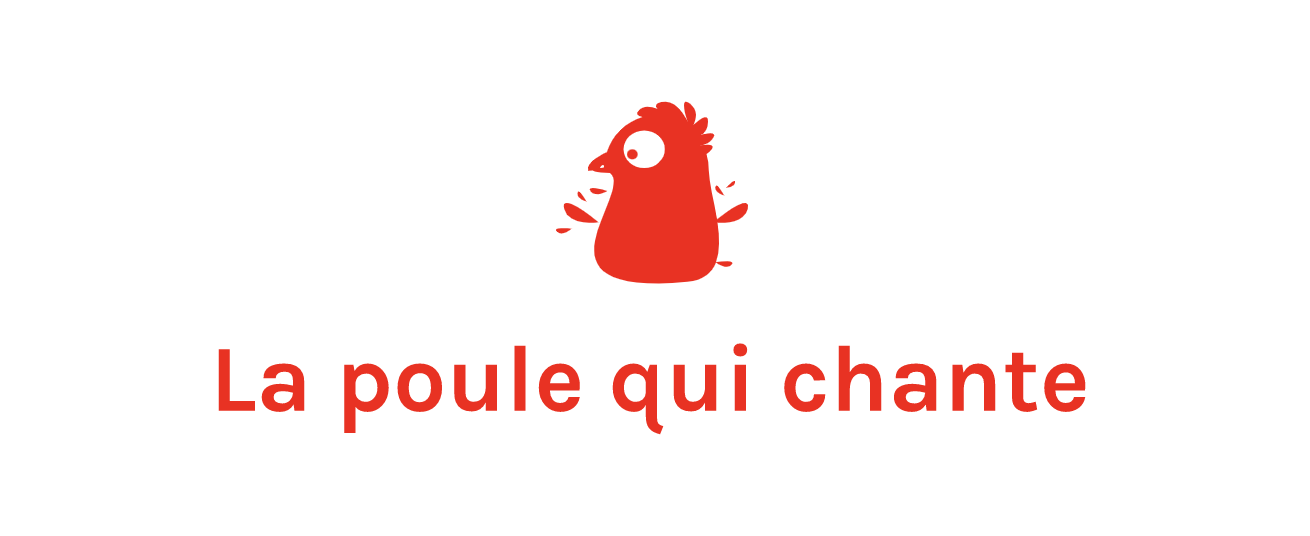

# Projet de d'importation des poulets à l'international: Etude de marché

### Objectif: Proposer une première analyse des groupes de pays que l’on peut cibler pour exporter nos poulets

***Méthodologie***: Créer des groupes assez homogènes et determiner ceux dans lesquels l'entreprise peut exporter du poulet.
Pour exporter, il faut des pays ayant un régime alimentaire assez riche en proteines animales, disposant d'un nombre suffisant de calories par habitant. il est également important que ces pays importent beaucoup de volaille.
Les pays ciblés sont ceux qui ont un regime alimentaire riche en proteine animale,
importent une part importante de leur disponibilité en volaille.
Pour parvenir à réaliser au mieux cette mission, nous allons utiliser 02 algorithmes de clustering permettent de partitionner les données en sous-groupes, ou clusters, de manière non supervisée. Intuitivement, ces sous-groupes regroupent entre elles des observations similaires.

.   ***La CAH ou classification Ascendante Hierarchique***:Elle cherche à ce que les individus regroupés au sein d’une même classe (homogénéité intra-classe) soient le plus semblables possibles tandis que les classes soient le plus dissemblables (hétérogénéité inter-classe).Elle nous permettra de construire un dendrogramme contenant l'ensemble des pays étudiés.

.   ***Le K-Means***: qui est un algorithme non supervisé de clustering non hiérarchique. Il permet de regrouper en  k clusters distincts les observations du dataset, les données similaires se retrouveront dans un même cluster. 

***Une ACP ou Analyse en Composantes Principales*** va nous permettre de reduire notre dimensionnalité en identifiant les liens entre variables et visualiser des observations dans un espace à deux ou trois dimensions, afin d'identifier des groupes homogènes d'observations, ou au contraire des observations atypiques.Elle nous sera d'une importance capitale sur le choix des pays

***Données***
Nous avons mis en place une étude de marché basé sur plusieurs critères. Le site de la FAO nous a permi d'avoir des données fiables et disponibles pour tous les pays.
Nous avons récupéré les données sous forme de fichiers CSV qui ont été traités à l’aide du langage Python. Les données primaires ont été récupérées sur le site de la FAO :

 Un fichier de disponiblité alimentaire en kcal par personnes pour chaque pays
 
 Un fichier de disponibilité totale en protéines etde disponibilité en protéines uniquement d’origine animales pour chaque pays
 Les données de populations (2015 à 2017)
 
 Les données sur les PIB par habitant
 
 La disponibilité intérieure en volaille
 
 La production de volaille
 
 les importations de volaille
 
Toutes ces données sont disponibles sur le site: http://www.fao.org/faostat/fr/#data

***Création du Dataframe de travail***

À partir de ces données brutes, nous avons calculé 3 indicateurs :

la variation de la population entre 2015 et 2017, en %, qui sera positive en cas de croissance ou négative en cas de baisse démographique ;

le ratio entre la quantité de protéines d’origine animale et la quantité totale de protéines consommées ;

le taux de dépendance aux importations de volaille, défini en économie comme le rapport entre les importations et la disponibilité intérieure du pays.


# Construction du fichier d'analyse

### Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import pandas
from sklearn import cluster, metrics
from sklearn.cluster import KMeans
import pandas
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

***Fichier de disponibilité en volaille***

In [2]:
dispo = pd.read_csv("DisponibiliteAlimentaire_2017.csv")
#supression des colonnes inutiles
dispo.drop(columns= ['Code Domaine','Domaine','Code Élément', 'Code Produit', 'Code année', 'Symbole', 'Description du Symbole','Année','Code zone'], inplace=True, axis=1)
#selection du produit volaille
dispo1 = dispo[dispo.Produit == 'Viande de Volailles']
#Table pivot
dispo2 = dispo1.pivot_table('Valeur', index='Zone', columns='Élément')
dispo2.reset_index(inplace=True)
#supression des colonnes que nous n'utiliserons pas
dispo2.drop(columns= ['Pertes', 'Variation de stock','Nourriture','Alimentation pour touristes','Disponibilité alimentaire en quantité (kg/personne/an)','Exportations - Quantité','Autres utilisations (non alimentaire)','Aliments pour animaux', 'Disponibilité de matière grasse en quantité (g/personne/jour)','Semences', 'Traitement','Résidus'], inplace=True, axis=1)
dispo2.rename(columns = {'Importations - Quantité':'importations'}, inplace=True)
dispo2.rename(columns = {'Disponibilité de protéines en quantité (g/personne/jour)':'Proteine de vollaille(g/per/jour)'}, inplace=True)
dispo2.head(3)

Élément,Zone,Disponibilité alimentaire (Kcal/personne/jour),Proteine de vollaille(g/per/jour),Disponibilité intérieure,importations,Production
0,Afghanistan,5.0,0.54,57.0,29.0,28.0
1,Afrique du Sud,143.0,14.11,2118.0,514.0,1667.0
2,Albanie,85.0,6.26,47.0,38.0,13.0


***Fichier de proteines***

In [3]:
#fichier de dispo en proteine
proteine= pd.read_csv('dispo.csv')
proteine1= proteine.pivot_table('Valeur', index='Zone', columns='Produit')
proteine1.reset_index(inplace=True)
proteine1['part proteine animale'] =round((proteine1['Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans)']/proteine1['Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans)']*100),2)
proteine1.rename(columns = {'Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans)':'dispo proteine animale(g/pers/jour)',"Disponibilité alimentaire par habitant utilisée dans l'estimation de la prévalence de la sous-alimentation (kcal/personne/jour) (moyenne sur 3 ans)":'Dispo_alimentaire (Kcal)','Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans)':'Disponibilité proteine(g/per/jr)'}, inplace=True)
#proteine1.drop(columns= ['dispo proteine animale(g/pers/jour)'], inplace=True, axis=1)
proteine1.head(3)

Produit,Zone,Dispo_alimentaire (Kcal),dispo proteine animale(g/pers/jour),Disponibilité proteine(g/per/jr),part proteine animale
0,Afghanistan,2260.0,11.3,56.0,20.18
1,Afrique du Sud,2905.0,36.3,84.3,43.06
2,Albanie,3350.0,61.7,115.3,53.51


***Jointure entre les fichiers de disponibilité***

In [4]:
dispo_df= pd.merge(dispo2, proteine1, how='left', on=['Zone'])
dispo_df.head(2)

,Zone,Disponibilité alimentaire (Kcal/personne/jour),Proteine de vollaille(g/per/jour),Disponibilité intérieure,importations,Production,Dispo_alimentaire (Kcal),dispo proteine animale(g/pers/jour),Disponibilité proteine(g/per/jr),part proteine animale
0,Afghanistan,5.0,0.54,57.0,29.0,28.0,2260.0,11.3,56.0,20.18
1,Afrique du Sud,143.0,14.11,2118.0,514.0,1667.0,2905.0,36.3,84.3,43.06


***Fichier de population***

In [5]:
# Lecture du fichier population
pop = pd.read_csv("Population_2000_2018.csv")
pop.drop(columns= ['Code Domaine','Domaine','Code Élément','Élément', 'Code Produit', 'Produit', 'Code année', 'Unité', 'Symbole', 'Description du Symbole', 'Note' ], inplace=True, axis=1)
#Convertir les unités de population
pop['Valeur'] = pop['Valeur'] * 1000
pop.rename(columns = {'Valeur':'Population'}, inplace=True)
#création du fichier des 03 dernières années
values=[2017,2016,2015]
pop_2012_2017 = pop[pop.Année.isin(values)]
#table pivot
df_pop= pd.DataFrame(pop_2012_2017.pivot_table('Population', index='Zone', columns='Année'))
df_pop.reset_index(inplace=True)
#Calcul des taux de croissance
df_pop['taux1']= ((df_pop[2017]-df_pop[2016])/df_pop[2016])*100
df_pop['taux2']= ((df_pop[2016]-df_pop[2015])/df_pop[2015])*100
#taux de croissance moyenne de la population au cours des 02 dernières années
df_pop['taux_crois_demo']=round((df_pop['taux1']+df_pop['taux2'])/2,2)
df_pop.drop(columns= [2015,2016,'taux1','taux2'], inplace=True)
#Rattachement de chaque pays à son continent
continent= pd.read_csv("continent.csv", sep=';')
pop_dat= pd.merge(df_pop, continent, how='left', on=['Zone'])
pop_dat.head(3)

,Zone,2017,taux_crois_demo,Continent
0,Afghanistan,36296113.0,2.70,Asie
1,Afrique du Sud,57009756.0,1.45,Afrique
2,Albanie,2884169.0,-0.11,Europe


***Fusion entre les fichiers de population et de disponibilité***

In [6]:
dispo3 = pd.merge(dispo_df, pop_dat, how='left', on=['Zone'])
dispo3.head(3)

,Zone,Disponibilité alimentaire (Kcal/personne/jour),Proteine de vollaille(g/per/jour),Disponibilité intérieure,importations,Production,Dispo_alimentaire (Kcal),dispo proteine animale(g/pers/jour),Disponibilité proteine(g/per/jr),part proteine animale,2017,taux_crois_demo,Continent
0,Afghanistan,5.0,0.54,57.0,29.0,28.0,2260.0,11.3,56.0,20.18,36296113.0,2.70,Asie
1,Afrique du Sud,143.0,14.11,2118.0,514.0,1667.0,2905.0,36.3,84.3,43.06,57009756.0,1.45,Afrique
2,Albanie,85.0,6.26,47.0,38.0,13.0,3350.0,61.7,115.3,53.51,2884169.0,-0.11,Europe


***Fichier de variables macroéconomiques***

In [7]:
macro = pd.read_csv("stat_macro.csv")
# table pivot
macro1 = macro.pivot_table('Valeur', index='Zone', columns='Élément')
macro1.reset_index(inplace=True)
macro1.rename(columns = {'Croissance annuelle US$':'taux de croissance PIB', 'Valeur US $ par habitant':'PIB/hbt'}, inplace=True)
macro1.head(3)

Élément,Zone,taux de croissance PIB,PIB/hbt
0,Afghanistan,3.245378,513.085978
1,Afrique du Sud,17.771989,6121.876572
2,Albanie,9.765944,4514.204908


***Jointure entre les deux fichiers***

In [8]:
data= pd.merge(dispo3, macro1, how='left', on=['Zone'])
data.head(3)

,Zone,Disponibilité alimentaire (Kcal/personne/jour),Proteine de vollaille(g/per/jour),Disponibilité intérieure,importations,Production,Dispo_alimentaire (Kcal),dispo proteine animale(g/pers/jour),Disponibilité proteine(g/per/jr),part proteine animale,2017,taux_crois_demo,Continent,taux de croissance PIB,PIB/hbt
0,Afghanistan,5.0,0.54,57.0,29.0,28.0,2260.0,11.3,56.0,20.18,36296113.0,2.70,Asie,3.245378,513.085978
1,Afrique du Sud,143.0,14.11,2118.0,514.0,1667.0,2905.0,36.3,84.3,43.06,57009756.0,1.45,Afrique,17.771989,6121.876572
2,Albanie,85.0,6.26,47.0,38.0,13.0,3350.0,61.7,115.3,53.51,2884169.0,-0.11,Europe,9.765944,4514.204908


In [9]:
data.shape

(172, 15)

## Nettoyage du fichier

In [10]:
data.columns

Index([                                          'Zone',
       'Disponibilité alimentaire (Kcal/personne/jour)',
                    'Proteine de vollaille(g/per/jour)',
                             'Disponibilité intérieure',
                                         'importations',
                                           'Production',
                             'Dispo_alimentaire (Kcal)',
                  'dispo proteine animale(g/pers/jour)',
                     'Disponibilité proteine(g/per/jr)',
                                'part proteine animale',
                                                   2017,
                                      'taux_crois_demo',
                                            'Continent',
                               'taux de croissance PIB',
                                              'PIB/hbt'],
      dtype='object')

In [11]:
#supression des colonnes inutiles
data.drop(columns= ['Disponibilité alimentaire (Kcal/personne/jour)','Disponibilité proteine(g/per/jr)'],inplace=True, axis=1)
data.rename(columns = {2017:'population'}, inplace=True)
data.head(3)

,Zone,Proteine de vollaille(g/per/jour),Disponibilité intérieure,importations,Production,Dispo_alimentaire (Kcal),dispo proteine animale(g/pers/jour),part proteine animale,population,taux_crois_demo,Continent,taux de croissance PIB,PIB/hbt
0,Afghanistan,0.54,57.0,29.0,28.0,2260.0,11.3,20.18,36296113.0,2.70,Asie,3.245378,513.085978
1,Afrique du Sud,14.11,2118.0,514.0,1667.0,2905.0,36.3,43.06,57009756.0,1.45,Afrique,17.771989,6121.876572
2,Albanie,6.26,47.0,38.0,13.0,3350.0,61.7,53.51,2884169.0,-0.11,Europe,9.765944,4514.204908


***Traitement des valeurs manquantes***

In [12]:
data.isnull().sum()

Zone                                   0
Proteine de vollaille(g/per/jour)      0
Disponibilité intérieure               2
importations                           2
Production                             4
Dispo_alimentaire (Kcal)               0
dispo proteine animale(g/pers/jour)    0
part proteine animale                  0
population                             0
taux_crois_demo                        0
Continent                              0
taux de croissance PIB                 1
PIB/hbt                                1
dtype: int64

In [13]:
# On supprime les pays qui ont des valeurs manquantes sur les valeurs clés de notre dataset
data.dropna(subset = ['Production', 'Disponibilité intérieure'],inplace=True)
data.dropna(subset = ['PIB/hbt'],inplace=True)
data.isnull().sum()

Zone                                   0
Proteine de vollaille(g/per/jour)      0
Disponibilité intérieure               0
importations                           0
Production                             0
Dispo_alimentaire (Kcal)               0
dispo proteine animale(g/pers/jour)    0
part proteine animale                  0
population                             0
taux_crois_demo                        0
Continent                              0
taux de croissance PIB                 0
PIB/hbt                                0
dtype: int64

In [14]:
data.shape

(167, 13)

***Calcul des indicateurs***

In [15]:
#Création des indicateurs
data['taux de dependance']= round((data['importations']/data['Disponibilité intérieure'])*100,2)
data['taux autosuffisance']= round((data['Production']/data['Disponibilité intérieure'])*100,2)
#Retrait du pays 'France' sur notre échantillon 
data = data[data['Zone'] != 'France']
data.head(3)

,Zone,Proteine de vollaille(g/per/jour),Disponibilité intérieure,importations,Production,Dispo_alimentaire (Kcal),dispo proteine animale(g/pers/jour),part proteine animale,population,taux_crois_demo,Continent,taux de croissance PIB,PIB/hbt,taux de dependance,taux autosuffisance
0,Afghanistan,0.54,57.0,29.0,28.0,2260.0,11.3,20.18,36296113.0,2.70,Asie,3.245378,513.085978,50.88,49.12
1,Afrique du Sud,14.11,2118.0,514.0,1667.0,2905.0,36.3,43.06,57009756.0,1.45,Afrique,17.771989,6121.876572,24.27,78.71
2,Albanie,6.26,47.0,38.0,13.0,3350.0,61.7,53.51,2884169.0,-0.11,Europe,9.765944,4514.204908,80.85,27.66


In [16]:
data.to_csv('df_cluster.csv')

# Classification Ascendante Hierarchique: Construction du dendrogramme et caractérisation des clusters
 

Nous allons créér un sous fichier de travail

In [17]:
#on crée un fichier sur les variables retenues dans notre analyse
X= data[['Dispo_alimentaire (Kcal)','Disponibilité intérieure','dispo proteine animale(g/pers/jour)','part proteine animale','taux de dependance','Zone','Production','taux_crois_demo','PIB/hbt']]
X.set_index('Zone',inplace = True)
X_pays= X.index
Pays = str(X_pays)
X.head(2)

,Dispo_alimentaire (Kcal),Disponibilité intérieure,dispo proteine animale(g/pers/jour),part proteine animale,taux de dependance,Production,taux_crois_demo,PIB/hbt
Zone,,,,,,,,
Afghanistan,2260.0,57.0,11.3,20.18,50.88,28.0,2.70,513.085978
Afrique du Sud,2905.0,2118.0,36.3,43.06,24.27,1667.0,1.45,6121.876572


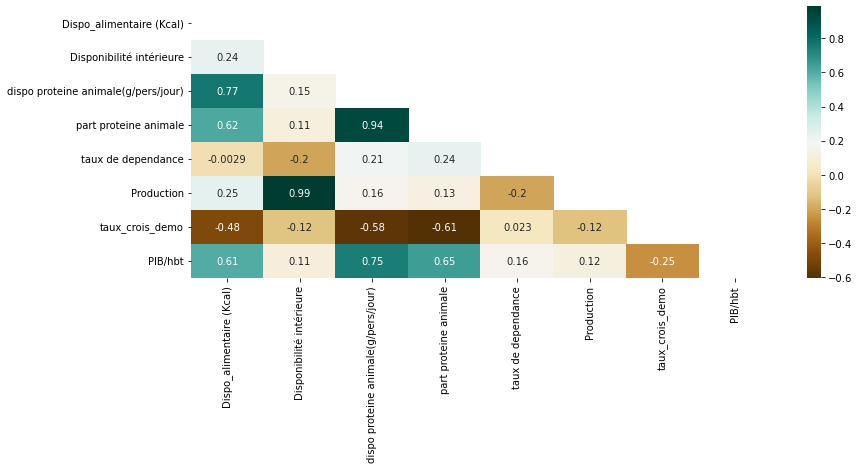

In [18]:
matrix = X.corr()
# Triangle de corrélations
mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(13, 5))
sns.heatmap(matrix, mask=mask, annot=True, cmap='BrBG')
plt.show()

### Normalisartion des données

In [19]:
# Normalization
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
role = pd.DataFrame(X_scaled, columns=X.columns)
role.head(2)

,Dispo_alimentaire (Kcal),Disponibilité intérieure,dispo proteine animale(g/pers/jour),part proteine animale,taux de dependance,Production,taux_crois_demo,PIB/hbt
0,-1.359587,-0.287078,-1.237888,-1.386215,0.105814,-0.275733,1.262921,-0.698770
1,0.089385,0.647823,-0.012081,0.048859,-0.406628,0.377852,0.156452,-0.409769


## Construction du dendrogramme

In [20]:
from matplotlib import pyplot as plt 
from scipy.cluster.hierarchy import dendrogram, linkage 
import scipy.cluster.hierarchy as sch
#Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward
Z = linkage(X_scaled, method = 'ward', metric='euclidean')

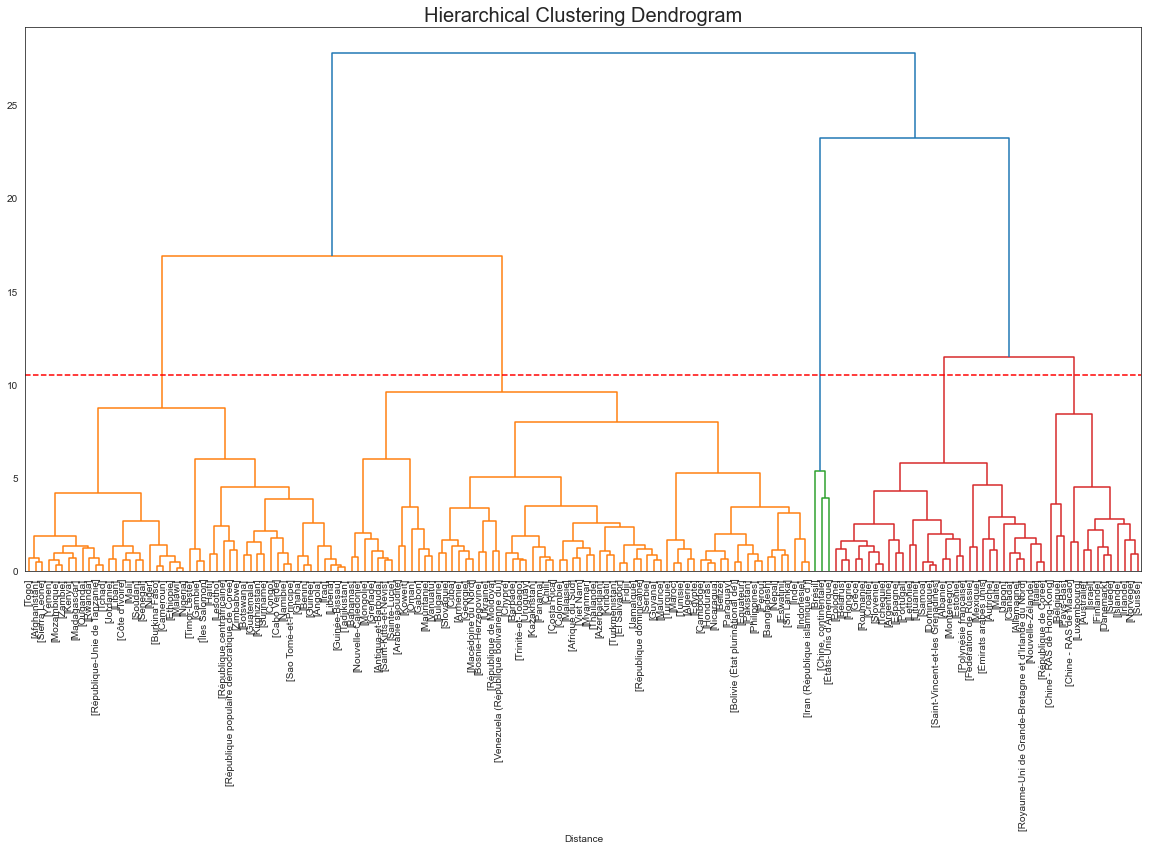

In [21]:
#Affichage d'un premier dendrogramme global
fig =plt.figure(figsize=(20,10))
sns.set_style('white')
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('Distance')
def pays(id):
    return '[%s]' % (X.index[id])

dendrogram(Z, leaf_font_size=10, leaf_label_func=pays, orientation='top')
plt.axhline(y=10.5, color='r', linestyle='--')
#plt.savefig("p5_graphic/dendrogramme.png")
plt.show()

On voit 05 grands groupes qui se dégagent

***Dendrogramme à 05 groupes***

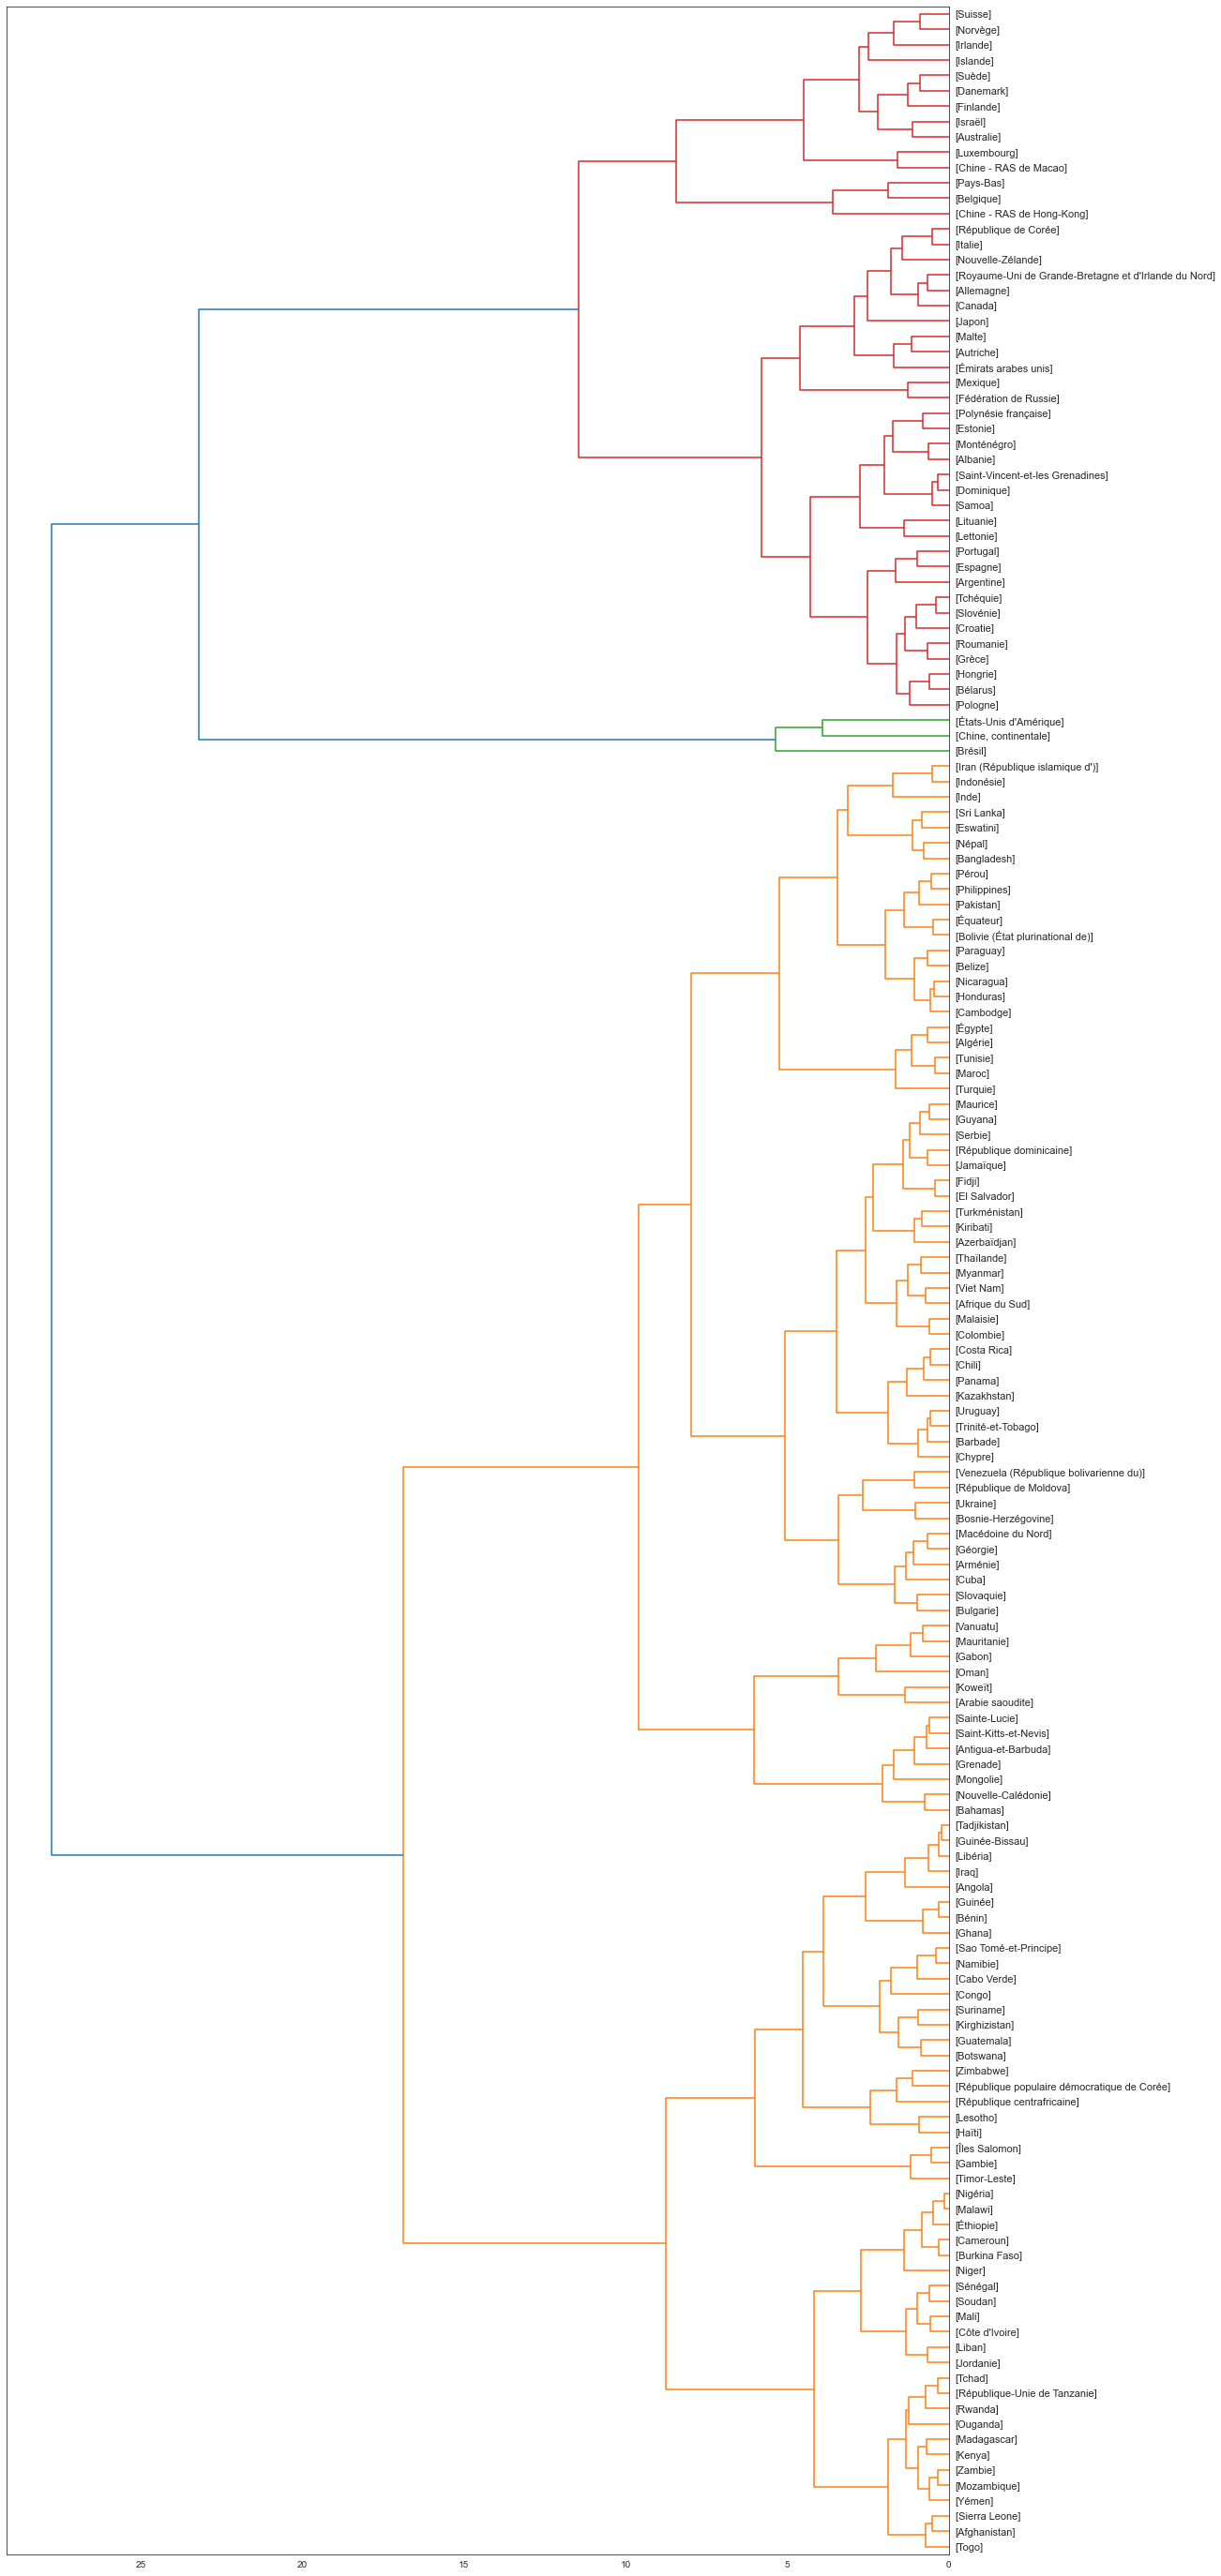

In [22]:
#Coupage du dendrogramme en 5 groupes pour avoir une première idée du partitionnement
import scipy.cluster.hierarchy as sch
import pylab
Z = linkage(X_scaled, method = 'ward', metric='euclidean')
fig = pylab.figure(figsize=(18,50))   
dendro = sch.dendrogram(Z,  p=5, leaf_label_func=pays, leaf_rotation=0, leaf_font_size =11, orientation = 'left')

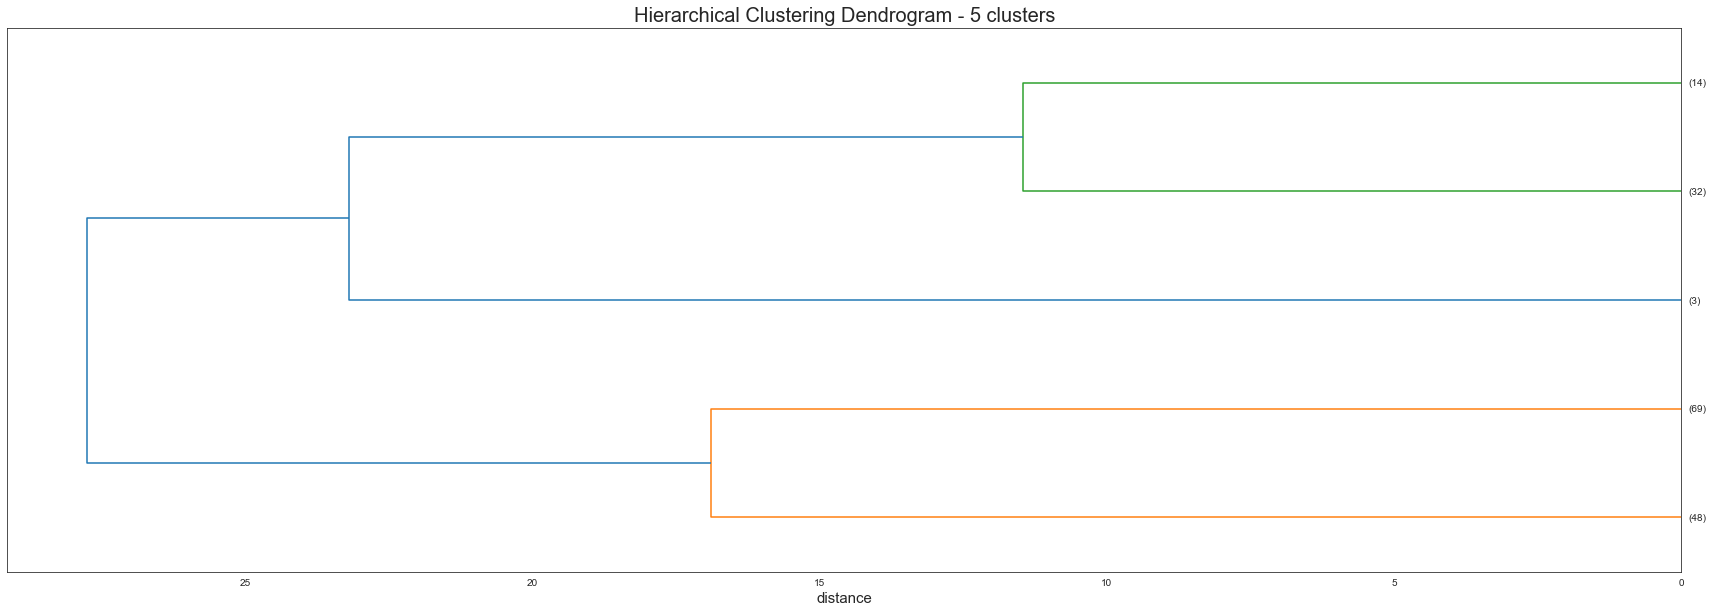

In [23]:
#Nombre de pays par groupes pour un partitionnement en 05 clusters
fig = plt.figure(figsize=(30,10))
plt.title('Hierarchical Clustering Dendrogram - 5 clusters', fontsize=20)
plt.xlabel('distance', fontsize=15)
dendrogram(Z, p=5, truncate_mode='lastp', leaf_font_size=10, orientation='left')
plt.show()

### Création du dataframe de pays avec leurs clusters d'appartenance

In [24]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
#Identification des 5 groupes obtenus
groupes_cah = fcluster(Z, 5, criterion='maxclust')
print('Numérotation de nos groupes : ' + str(np.unique(groupes_cah)))
#Index trié des groupes
idg = np.argsort(groupes_cah)
#Affichage des pays selon leurs groupes
df_cah = pd.DataFrame(X.index[idg], groupes_cah[idg]).reset_index()
df_cah = df_cah.rename(columns={'index':'Groupe'})
df_cah.head(2)
df_groupes_cah = pd.merge(X, df_cah, on='Zone')
df_groupes_cah.head(3)

Numérotation de nos groupes : [1 2 3 4 5]


,Zone,Dispo_alimentaire (Kcal),Disponibilité intérieure,dispo proteine animale(g/pers/jour),part proteine animale,taux de dependance,Production,taux_crois_demo,PIB/hbt,Groupe
0,Afghanistan,2260.0,57.0,11.3,20.18,50.88,28.0,2.70,513.085978,1
1,Afrique du Sud,2905.0,2118.0,36.3,43.06,24.27,1667.0,1.45,6121.876572,2
2,Albanie,3350.0,47.0,61.7,53.51,80.85,13.0,-0.11,4514.204908,4


### Caracterisation des groupes

***Distribution des variables de disponibilités selon les groupes de la CAH***

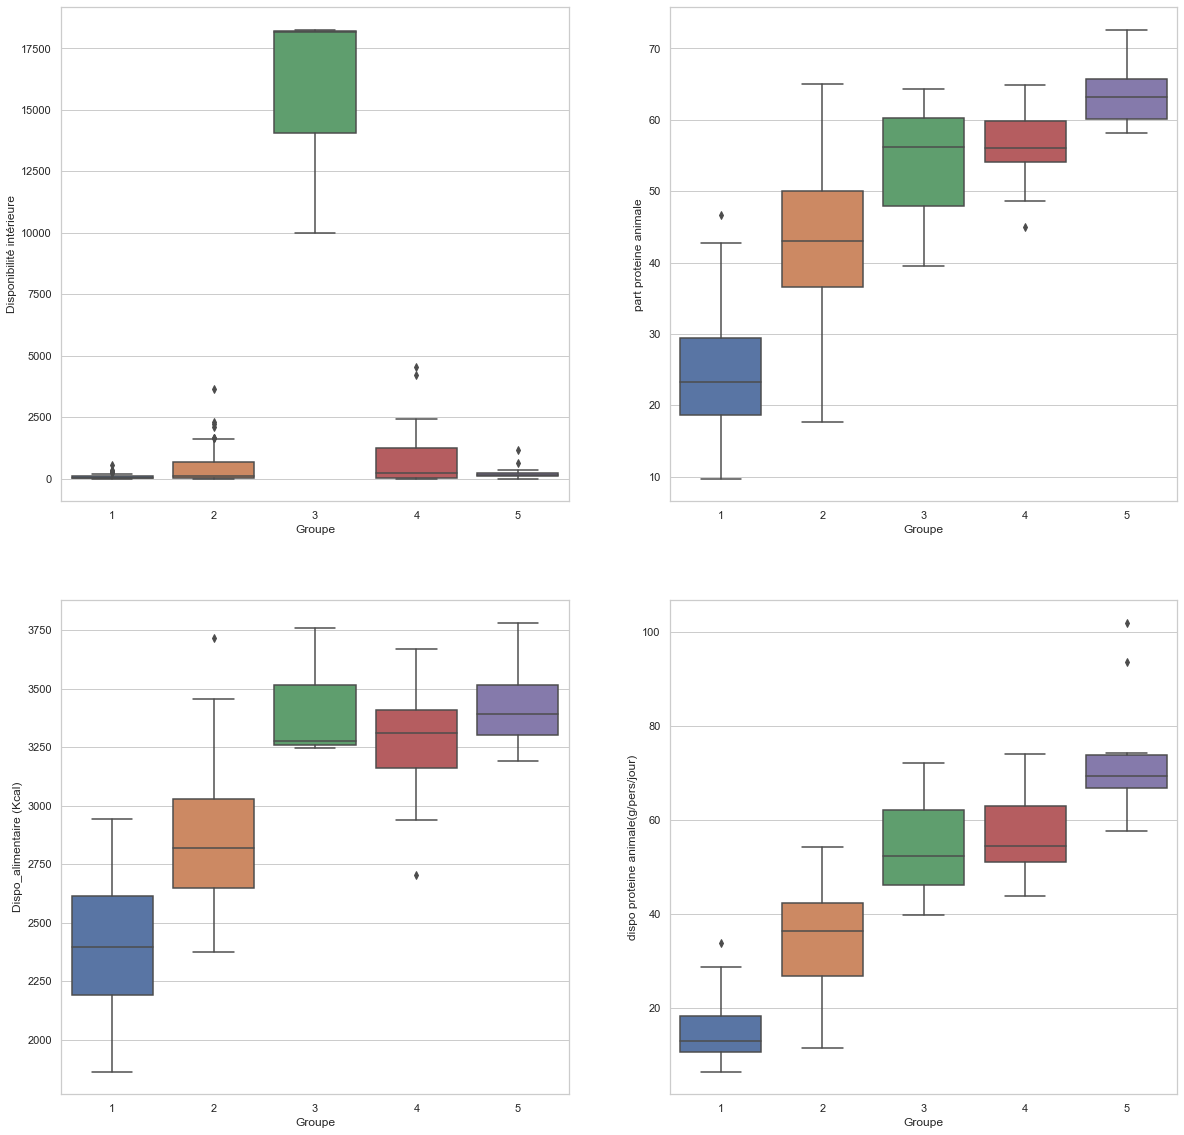

In [25]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='Disponibilité intérieure')

plt.subplot(222)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='part proteine animale')

plt.subplot(223)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='Dispo_alimentaire (Kcal)')

plt.subplot(224)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='dispo proteine animale(g/pers/jour)')
plt.savefig("P9_picture/boxplot_dendogramme.png")
plt.show(block=False)


***Distribution des variables de économiques et démographiques selon les groupes de la CAH***

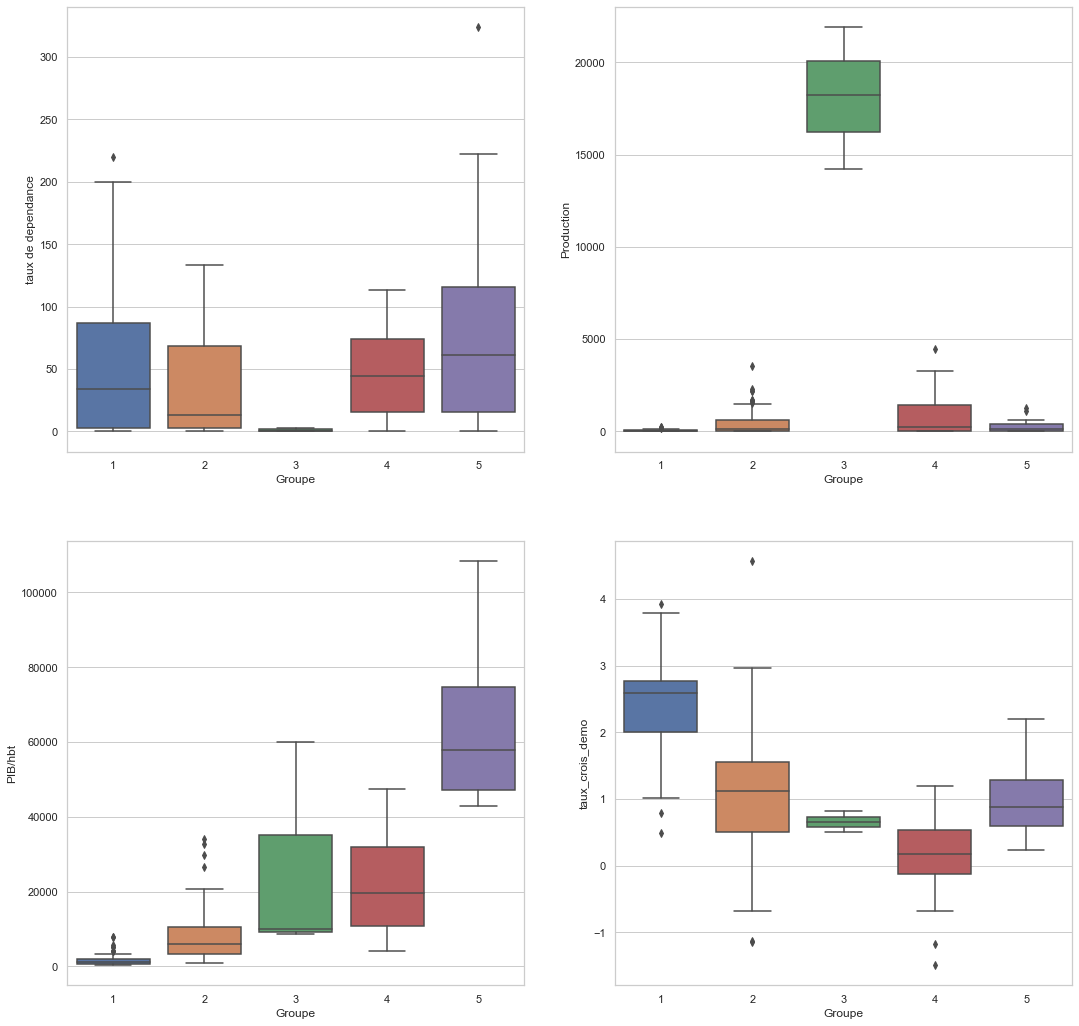

In [75]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(18, 18))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='taux de dependance')

plt.subplot(222)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='Production')
plt.subplot(223)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='PIB/hbt')
plt.subplot(224)
sns.boxplot(data=df_groupes_cah, x='Groupe', y='taux_crois_demo')

plt.savefig("P9_picture/boxplot_dendogramme2.png")
plt.show(block=False)


In [27]:
#Préparation de sous-ensembles permettant de caractériser les groupes un à un
df_groupe1_cah = df_groupes_cah[df_groupes_cah['Groupe'] == 1]
df_groupe2_cah = df_groupes_cah[df_groupes_cah['Groupe'] == 2]
df_groupe3_cah = df_groupes_cah[df_groupes_cah['Groupe'] == 3]
df_groupe4_cah = df_groupes_cah[df_groupes_cah['Groupe'] == 4]
df_groupe5_cah = df_groupes_cah[df_groupes_cah['Groupe'] == 5]

In [28]:
print(df_groupe1_cah['Zone'].unique())

['Afghanistan' 'Angola' 'Botswana' 'Burkina Faso' 'Bénin' 'Cabo Verde'
 'Cameroun' 'Congo' "Côte d'Ivoire" 'Gambie' 'Ghana' 'Guatemala' 'Guinée'
 'Guinée-Bissau' 'Haïti' 'Iraq' 'Jordanie' 'Kenya' 'Kirghizistan'
 'Lesotho' 'Liban' 'Libéria' 'Madagascar' 'Malawi' 'Mali' 'Mozambique'
 'Namibie' 'Niger' 'Nigéria' 'Ouganda' 'Rwanda'
 'République centrafricaine' 'République populaire démocratique de Corée'
 'République-Unie de Tanzanie' 'Sao Tomé-et-Principe' 'Sierra Leone'
 'Soudan' 'Suriname' 'Sénégal' 'Tadjikistan' 'Tchad' 'Timor-Leste' 'Togo'
 'Yémen' 'Zambie' 'Zimbabwe' 'Éthiopie' 'Îles Salomon']


In [29]:
print(df_groupe2_cah['Zone'].unique())

['Afrique du Sud' 'Algérie' 'Antigua-et-Barbuda' 'Arabie saoudite'
 'Arménie' 'Azerbaïdjan' 'Bahamas' 'Bangladesh' 'Barbade' 'Belize'
 'Bolivie (État plurinational de)' 'Bosnie-Herzégovine' 'Bulgarie'
 'Cambodge' 'Chili' 'Chypre' 'Colombie' 'Costa Rica' 'Cuba' 'El Salvador'
 'Eswatini' 'Fidji' 'Gabon' 'Grenade' 'Guyana' 'Géorgie' 'Honduras' 'Inde'
 'Indonésie' "Iran (République islamique d')" 'Jamaïque' 'Kazakhstan'
 'Kiribati' 'Koweït' 'Macédoine du Nord' 'Malaisie' 'Maroc' 'Maurice'
 'Mauritanie' 'Mongolie' 'Myanmar' 'Nicaragua' 'Nouvelle-Calédonie'
 'Népal' 'Oman' 'Pakistan' 'Panama' 'Paraguay' 'Philippines' 'Pérou'
 'République de Moldova' 'République dominicaine' 'Saint-Kitts-et-Nevis'
 'Sainte-Lucie' 'Serbie' 'Slovaquie' 'Sri Lanka' 'Thaïlande'
 'Trinité-et-Tobago' 'Tunisie' 'Turkménistan' 'Turquie' 'Ukraine'
 'Uruguay' 'Vanuatu' 'Venezuela (République bolivarienne du)' 'Viet Nam'
 'Égypte' 'Équateur']


In [30]:
print(df_groupe3_cah['Zone'].unique())

['Brésil' 'Chine, continentale' "États-Unis d'Amérique"]


In [31]:
print(df_groupe4_cah['Zone'].unique())

['Albanie' 'Allemagne' 'Argentine' 'Autriche' 'Bélarus' 'Canada' 'Croatie'
 'Dominique' 'Espagne' 'Estonie' 'Fédération de Russie' 'Grèce' 'Hongrie'
 'Italie' 'Japon' 'Lettonie' 'Lituanie' 'Malte' 'Mexique' 'Monténégro'
 'Nouvelle-Zélande' 'Pologne' 'Polynésie française' 'Portugal' 'Roumanie'
 "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord"
 'République de Corée' 'Saint-Vincent-et-les Grenadines' 'Samoa'
 'Slovénie' 'Tchéquie' 'Émirats arabes unis']


In [32]:
print(df_groupe5_cah['Zone'].unique())

['Australie' 'Belgique' 'Chine - RAS de Hong-Kong' 'Chine - RAS de Macao'
 'Danemark' 'Finlande' 'Irlande' 'Islande' 'Israël' 'Luxembourg' 'Norvège'
 'Pays-Bas' 'Suisse' 'Suède']


In [33]:

df_groupes_cah.groupby('Groupe').mean()

,Dispo_alimentaire (Kcal),Disponibilité intérieure,dispo proteine animale(g/pers/jour),part proteine animale,taux de dependance,Production,taux_crois_demo,PIB/hbt
Groupe,,,,,,,,
1,2397.333333,87.229167,14.793750,24.604583,51.399792,49.562500,2.417708,1880.815366
2,2862.449275,498.927536,34.266667,43.138406,33.567246,474.565217,1.084783,8296.401296
3,3425.666667,15469.666667,54.666667,53.370000,1.063333,18117.000000,0.656667,26235.037892
4,3274.187500,813.031250,56.640625,56.395625,48.083125,803.000000,0.156250,21961.091802
5,3428.071429,248.500000,72.550000,64.022143,86.341429,304.214286,0.963571,63726.397655


### Analyse des centroids et choix des pays selon la CAH

**Le groupe 1** est caractérisé par une faible disponibilté alimentaire, en proteine animale et intérieure en vollaille,sa production en poulet est très faible et ne consomme pas beaucoup de viande. il importe de la vollaille, mais son pouvoir d'achat est faible: **on l'exclut de la liste de clients potentiels**

**Le groupe 3** a une forte disponibilité intérieure, consomme beaucoup de viande, mais cette disponibilité est portée par une **production très élévée**, malgré un PIB/hbt très fort, ces pays importent très peu de poulets:  **on l'exclut de la liste de clients potentiels**

**Le groupe 2** a des disponibilités alimentaires et intérieure moyennes, il importe le tiers de sa disponibilité en vollaille, mais son PIB/hbt reste faible comparé aux groupes restants: **on l'exclut de la liste de clients potentiels**

**le groupe 4** consomme beaucoup de viande et en importe environ 48%, bien que la croissance de sa population(demande potentielle)soit faible, son PIB/hbt et ses disponibilités sont elevés par rapport au groupe3:**Nous pouvons l'introduire dans une moindre mesure dans la liste de clients potentiels**

**le groupe 5** a une forte disponibilité alimentaire, consomme beaucoup de proteine d'origine animale, ne produit pas trop de vollaille mais importe une pert importante de sa disponibilité intérieure(86,3%), par ailleurs, il a un PIB/hbt très elevé avec demande potentielle intéressante: **C'est le meilleur candidat pour importer du poulet**

**Sur l'idée d'un régime alimentaire potentiellement compatible avec les besoins en poulet, le pouvoir économique et la dépendance aux importations de vollaille: les pays des groupes 4 et 5 sont de bons candidats selon la CAH pour notre projet, mais nous allons retenir uniquement le groupe 5 ***

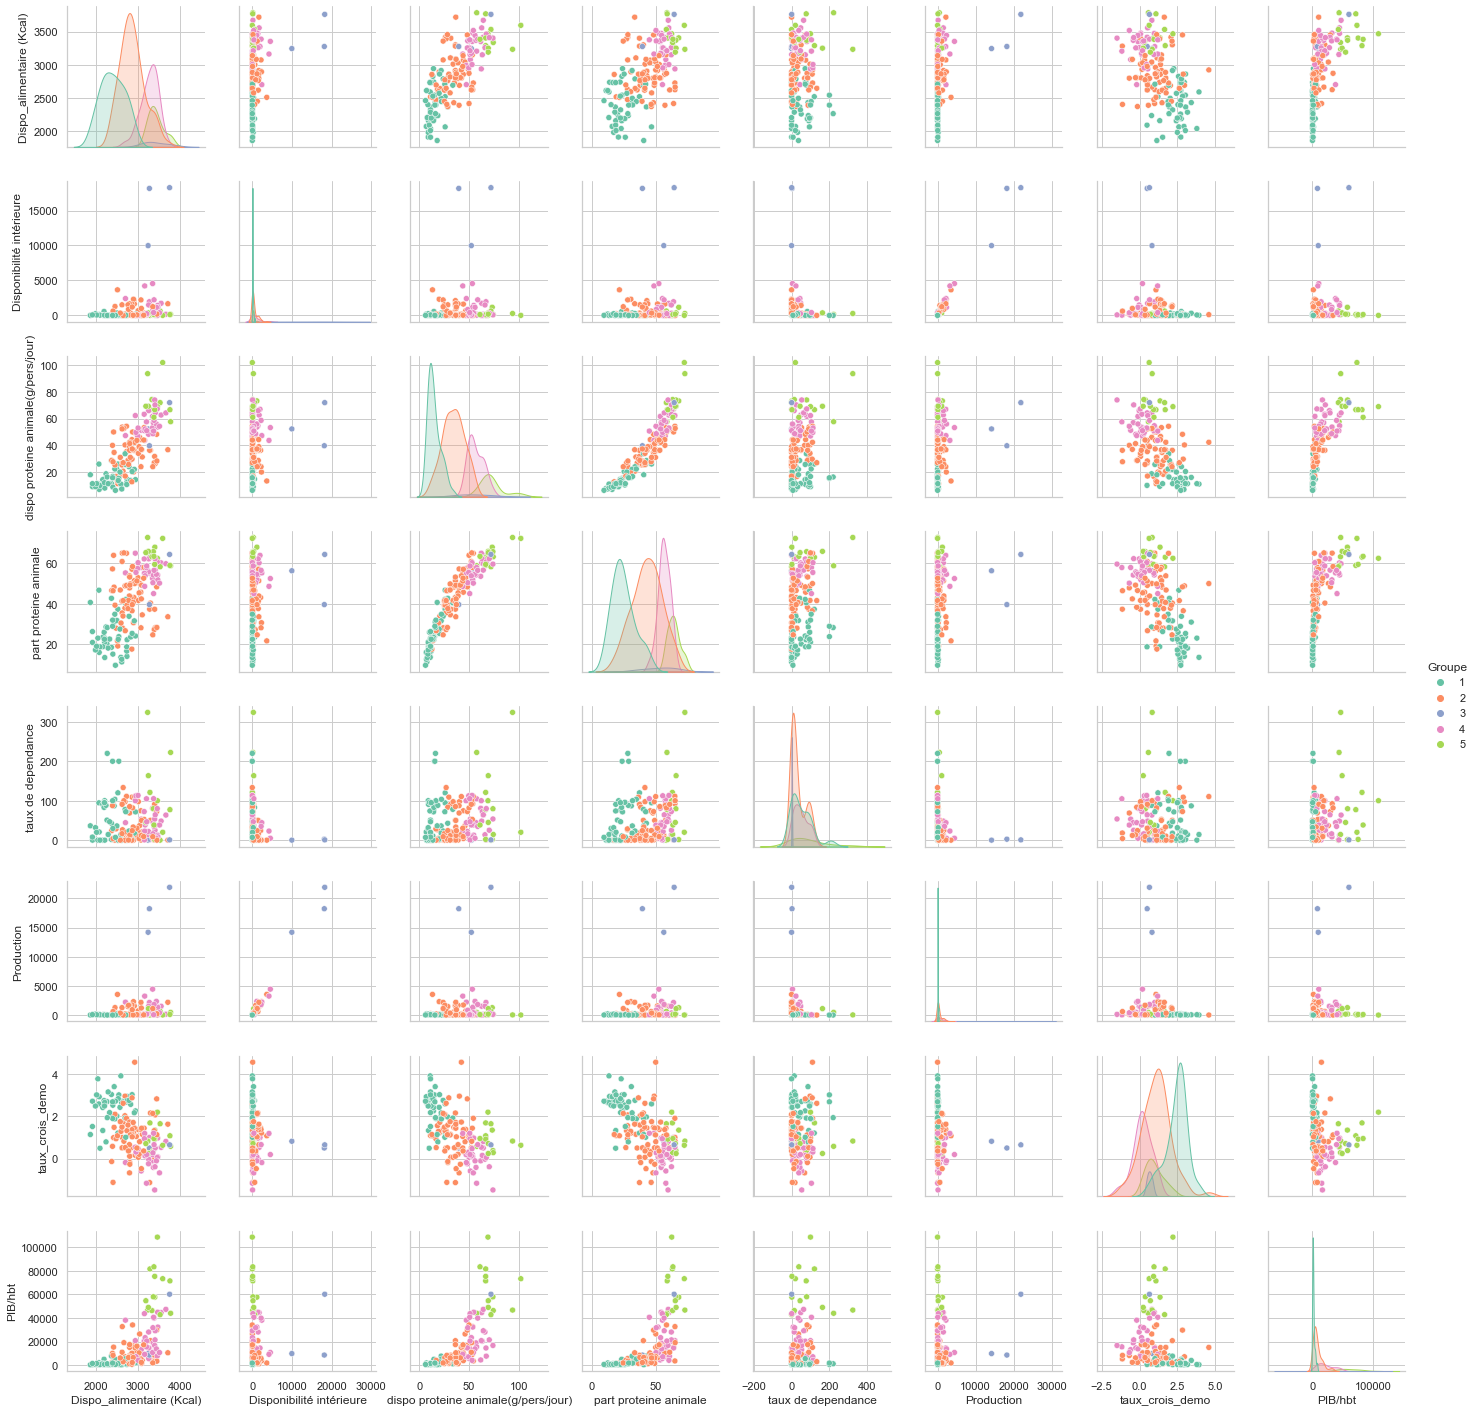

In [34]:
import seaborn as sns
sns.pairplot(df_groupes_cah, hue='Groupe',palette="Set2")

#### Sous-ensemble des groupes validés via la classification hiérarchique:
#### 'Australie', 'Belgique', 'Chine - RAS de Hong-Kong','Chine - RAS de Macao', 'Danemark', 'Finlande', 'Irlande',
####  'Islande', 'Israël', 'Luxembourg', 'Norvège', 'Pays-Bas', 'Suisse',  'Suède'              

# K-MEANS

Nous allons également partitionner notre échantillon avec la méthode de moyennes mobiles ou K-means

le coefficient de silhouette, la méthode de coude nous permettront choisir le nombre de clusters approprié. 

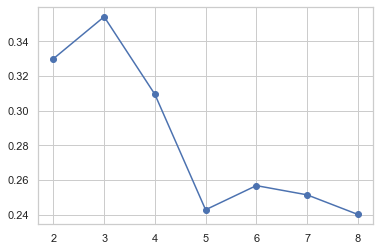

In [35]:
#Calcul  de la métrique "silhouette" pour différents nombres de groupes issus de la méthode des centres mobiles
silhouettes = [] 
#Boucle itérative de 2 à 9 (clusters) pour tester les possibilités
for k in range(2, 9): 
    #Création et ajustement d'un modèle pour chaque k
    cls = cluster.KMeans(n_clusters=k)  
    cls.fit(X_scaled)
    #Stockage des coefficients associés
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)    
#Visualisation des valeurs de coefficient de silhouette pour chaque nombre de cluster
plt.plot(range(2, 9), silhouettes, marker='o')
plt.show()

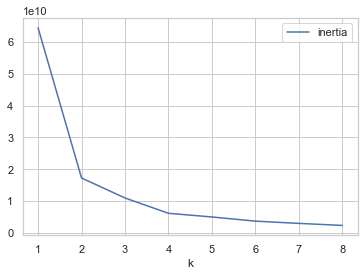

In [36]:
from sklearn.cluster import KMeans
import pandas
inertia = []
for k in range(1, 9):
    kmeans = KMeans(n_clusters = k, init = "random", n_init = 20).fit(X)
    inertia = inertia + [kmeans.inertia_]
inertia = pandas.DataFrame({"k": range(1, 9), "inertia": inertia})
inertia.plot.line(x = "k", y = "inertia")
#plt.scatter(2, inertia.query('k == 2')["inertia"], c = "red")
#plt.scatter(3, inertia.query('k == 3')["inertia"], c = "red")
plt.show()

***Le coefficient de silouhette suggère un decoupage en 3 clusters, cependant vu que nous avons déjà un partitionnement de 05 clusters , il est pertinent de faire également un K-Means à 05 groupes pour une meilleure comparaison*** 

In [37]:
#Clustering K-Means en 3 clusters
cls3 = cluster.KMeans(n_clusters=3, random_state=0)
cls3.fit(X_scaled)
pandas.Series(cls3.labels_).value_counts()

0    85
1    78
2     3
dtype: int64

In [38]:
##Clustering K-Means en 5 clusters
from sklearn.cluster import KMeans
cls5 = cluster.KMeans(n_clusters=5,random_state=0)
cls5.fit(X_scaled)
pandas.Series(cls5.labels_).value_counts()

2    51
4    48
1    45
0    19
3     3
dtype: int64

In [39]:
cls5.cluster_centers_

array([[ 1.30188695, -0.08684299,  1.58043558,  1.21607742,  0.61941148,
        -0.09380976, -0.30430499,  2.28361644],
       [-0.01794619,  0.04892959, -0.34419273, -0.22262887, -0.58759259,
         0.01616703, -0.11323135, -0.44850856],
       [-1.0174632 , -0.272358  , -1.02512594, -1.06441537,  0.17419333,
        -0.26663183,  1.07078614, -0.61856877],
       [ 1.2590464 ,  6.70434054,  0.88847846,  0.69551993, -0.85353002,
         6.93763175, -0.54578703,  0.62659218],
       [ 0.50385854, -0.14113704,  0.730758  ,  0.81482192,  0.17394955,
        -0.12832923, -0.87699014,  0.13461257]])

***Le partitionnement en 03 clusters nous donne 02 groupes de très grande taille et 01 de très petite taille***

In [40]:
#Récupération des clusters attribués à chaque individu (classes d'appartenance)
clusters_kmeans3 = cls3.labels_
clusters_kmeans5 = cls5.labels_

In [41]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

#Identification des 5 groupes obtenus
groupes_kmean5 = clusters_kmeans5
print('Numérotation de nos groupes : ' + str(np.unique(groupes_kmean5)))
#Index trié des groupes
idg = np.argsort(groupes_kmean5)
#Affichage des pays selon leurs groupes
df_kmean5 = pd.DataFrame(X.index[idg], groupes_kmean5[idg]).reset_index()
df_kmean5 = df_kmean5.rename(columns={'index':'Groupe'})

#Identification des 03 groupes obtenus
groupes_kmean3 = clusters_kmeans3
print('Numérotation de nos groupes : ' + str(np.unique(groupes_kmean3)))
#Index trié des groupes
idg = np.argsort(groupes_kmean3)
#Affichage des pays selon leurs groupes
df_kmean3 = pd.DataFrame(X.index[idg], groupes_kmean3[idg]).reset_index()
df_kmean3 = df_kmean3.rename(columns={'index':'Groupe'})


Numérotation de nos groupes : [0 1 2 3 4]
Numérotation de nos groupes : [0 1 2]


### Création du dataframe de pays avec leurs clusters d'appartenance pour k=03

In [42]:
df_groupes_kmean3 = pd.merge(X, df_kmean3, on='Zone')
df_groupe0_Kmeans3 = df_groupes_kmean3[df_groupes_kmean3['Groupe'] == 0]
df_groupe1_Kmeans3 = df_groupes_kmean3[df_groupes_kmean3['Groupe'] == 1]
df_groupe2_Kmeans3 = df_groupes_kmean3[df_groupes_kmean3['Groupe'] == 2]
print(df_groupe0_Kmeans3['Zone'].unique())

['Afghanistan' 'Afrique du Sud' 'Algérie' 'Angola' 'Azerbaïdjan'
 'Bangladesh' 'Belize' 'Bolivie (État plurinational de)' 'Botswana'
 'Burkina Faso' 'Bénin' 'Cabo Verde' 'Cambodge' 'Cameroun' 'Congo'
 "Côte d'Ivoire" 'El Salvador' 'Eswatini' 'Fidji' 'Gabon' 'Gambie' 'Ghana'
 'Guatemala' 'Guinée' 'Guinée-Bissau' 'Guyana' 'Géorgie' 'Haïti'
 'Honduras' 'Inde' 'Indonésie' "Iran (République islamique d')" 'Iraq'
 'Jordanie' 'Kenya' 'Kirghizistan' 'Lesotho' 'Liban' 'Libéria'
 'Madagascar' 'Malawi' 'Mali' 'Maroc' 'Mauritanie' 'Mozambique' 'Myanmar'
 'Namibie' 'Nicaragua' 'Niger' 'Nigéria' 'Népal' 'Oman' 'Ouganda'
 'Pakistan' 'Paraguay' 'Philippines' 'Pérou' 'Rwanda'
 'République centrafricaine' 'République de Moldova'
 'République dominicaine' 'République populaire démocratique de Corée'
 'République-Unie de Tanzanie' 'Sao Tomé-et-Principe' 'Sierra Leone'
 'Soudan' 'Sri Lanka' 'Suriname' 'Sénégal' 'Tadjikistan' 'Tchad'
 'Thaïlande' 'Timor-Leste' 'Togo' 'Tunisie' 'Turkménistan' 'Vanuatu'
 'Vie

In [43]:
print(df_groupe1_Kmeans3['Zone'].unique())

['Albanie' 'Allemagne' 'Antigua-et-Barbuda' 'Arabie saoudite' 'Argentine'
 'Arménie' 'Australie' 'Autriche' 'Bahamas' 'Barbade' 'Belgique'
 'Bosnie-Herzégovine' 'Bulgarie' 'Bélarus' 'Canada' 'Chili'
 'Chine - RAS de Hong-Kong' 'Chine - RAS de Macao' 'Chypre' 'Colombie'
 'Costa Rica' 'Croatie' 'Cuba' 'Danemark' 'Dominique' 'Espagne' 'Estonie'
 'Finlande' 'Fédération de Russie' 'Grenade' 'Grèce' 'Hongrie' 'Irlande'
 'Islande' 'Israël' 'Italie' 'Jamaïque' 'Japon' 'Kazakhstan' 'Kiribati'
 'Koweït' 'Lettonie' 'Lituanie' 'Luxembourg' 'Macédoine du Nord'
 'Malaisie' 'Malte' 'Maurice' 'Mexique' 'Mongolie' 'Monténégro' 'Norvège'
 'Nouvelle-Calédonie' 'Nouvelle-Zélande' 'Panama' 'Pays-Bas' 'Pologne'
 'Polynésie française' 'Portugal' 'Roumanie'
 "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord"
 'République de Corée' 'Saint-Kitts-et-Nevis'
 'Saint-Vincent-et-les Grenadines' 'Sainte-Lucie' 'Samoa' 'Serbie'
 'Slovaquie' 'Slovénie' 'Suisse' 'Suède' 'Tchéquie' 'Trinité-et-Tobago'
 'Turquie' 'Ukra

In [44]:
print(df_groupe2_Kmeans3['Zone'].unique())

['Brésil' 'Chine, continentale' "États-Unis d'Amérique"]


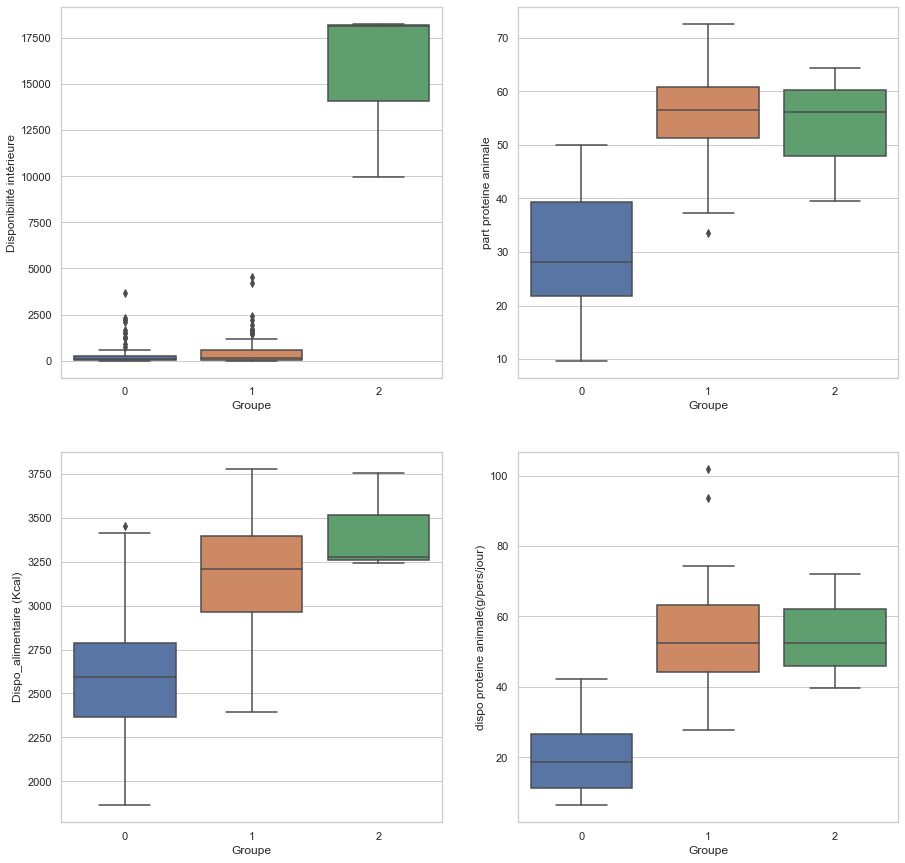

In [45]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(15, 15))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df_groupes_kmean3, x='Groupe', y='Disponibilité intérieure')

plt.subplot(222)
sns.boxplot(data=df_groupes_kmean3, x='Groupe', y='part proteine animale')

plt.subplot(223)
sns.boxplot(data=df_groupes_kmean3, x='Groupe', y='Dispo_alimentaire (Kcal)')

plt.subplot(224)
sns.boxplot(data=df_groupes_kmean3, x='Groupe', y='dispo proteine animale(g/pers/jour)')



<function matplotlib.pyplot.show(*args, **kw)>

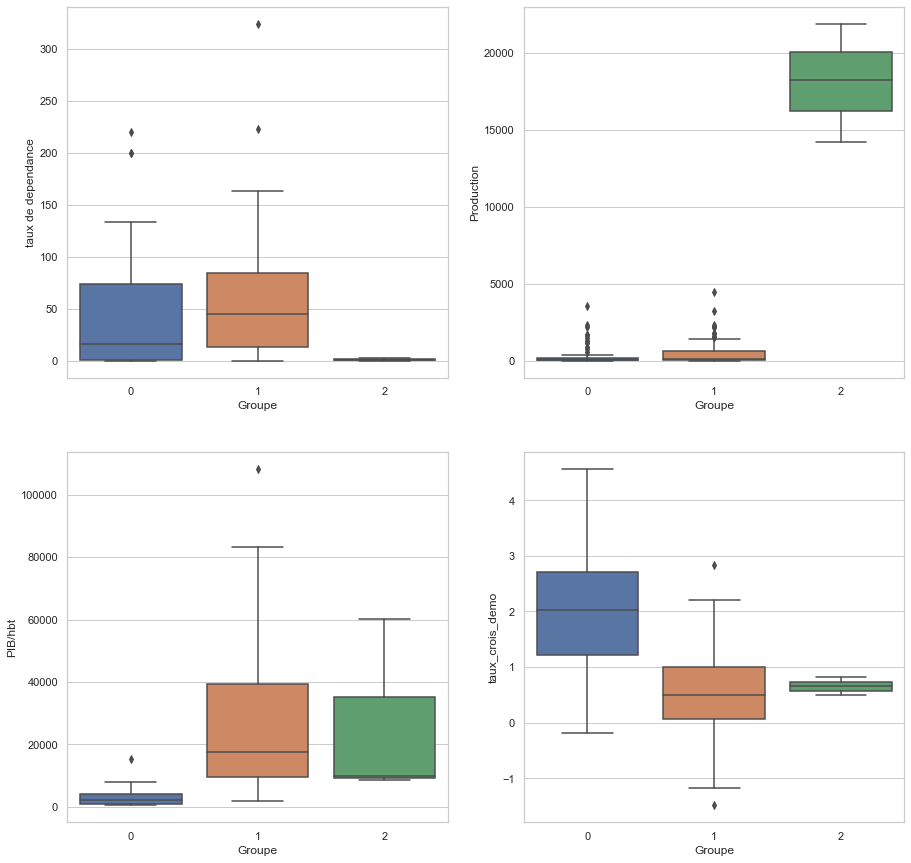

In [46]:
plt.figure(figsize=(15, 15))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=df_groupes_kmean3, x='Groupe', y='taux de dependance')

plt.subplot(222)
sns.boxplot(data=df_groupes_kmean3, x='Groupe', y='Production')

plt.subplot(223)
sns.boxplot(data=df_groupes_kmean3, x='Groupe', y='PIB/hbt')

plt.subplot(224)
sns.boxplot(data=df_groupes_kmean3, x='Groupe', y='taux_crois_demo')

plt.savefig("P9_picture/boxplot_k-means3.png")
plt.show

***Le partitionnement à 03 clusters ne semblent pas pertinent pour notre projet, nous allons nous concentrer dans le clustering à k=5***

### Création du dataframe de pays avec leurs clusters d'appartenance pour k=05

In [47]:
df_groupes_kmean5 = pd.merge(X, df_kmean5, on='Zone')
df_groupes_kmean5.head(5)

,Zone,Dispo_alimentaire (Kcal),Disponibilité intérieure,dispo proteine animale(g/pers/jour),part proteine animale,taux de dependance,Production,taux_crois_demo,PIB/hbt,Groupe
0,Afghanistan,2260.0,57.0,11.3,20.18,50.88,28.0,2.70,513.085978,2
1,Afrique du Sud,2905.0,2118.0,36.3,43.06,24.27,1667.0,1.45,6121.876572,1
2,Albanie,3350.0,47.0,61.7,53.51,80.85,13.0,-0.11,4514.204908,4
3,Algérie,3414.0,277.0,26.3,28.19,0.72,275.0,2.07,4109.701336,1
4,Allemagne,3555.0,1739.0,62.7,60.12,48.42,1514.0,0.53,44552.061000,0


In [48]:
#Préparation de sous-ensembles permettant de caractériser les groupes un à un
df_groupe0_Kmeans = df_groupes_kmean5[df_groupes_kmean5['Groupe'] == 0]
df_groupe1_Kmeans = df_groupes_kmean5[df_groupes_kmean5['Groupe'] == 1]
df_groupe2_Kmeans = df_groupes_kmean5[df_groupes_kmean5['Groupe'] == 2]
df_groupe3_Kmeans= df_groupes_kmean5[df_groupes_kmean5['Groupe'] == 3]
df_groupe4_Kmeans = df_groupes_kmean5[df_groupes_kmean5['Groupe'] == 4]

<function matplotlib.pyplot.show(*args, **kw)>

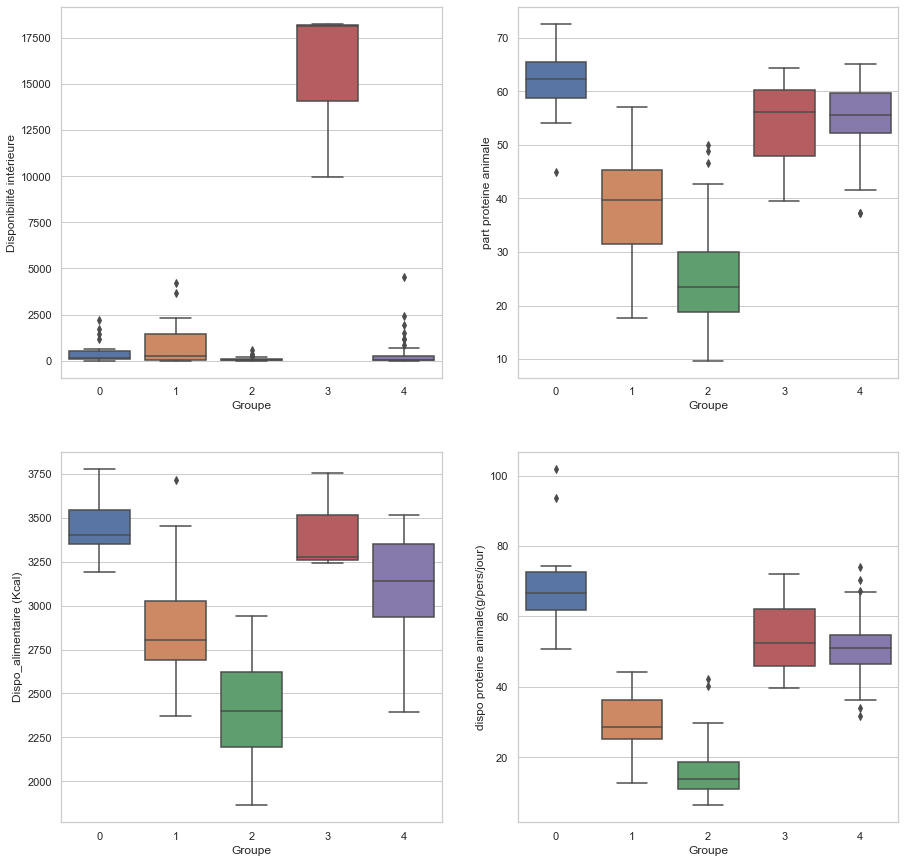

In [49]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(15, 15))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df_groupes_kmean5, x='Groupe', y='Disponibilité intérieure')

plt.subplot(222)
sns.boxplot(data=df_groupes_kmean5, x='Groupe', y='part proteine animale')

plt.subplot(223)
sns.boxplot(data=df_groupes_kmean5, x='Groupe', y='Dispo_alimentaire (Kcal)')

plt.subplot(224)
sns.boxplot(data=df_groupes_kmean5, x='Groupe', y='dispo proteine animale(g/pers/jour)')
plt.savefig("P9_picture/boxplot_k-means5.png")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

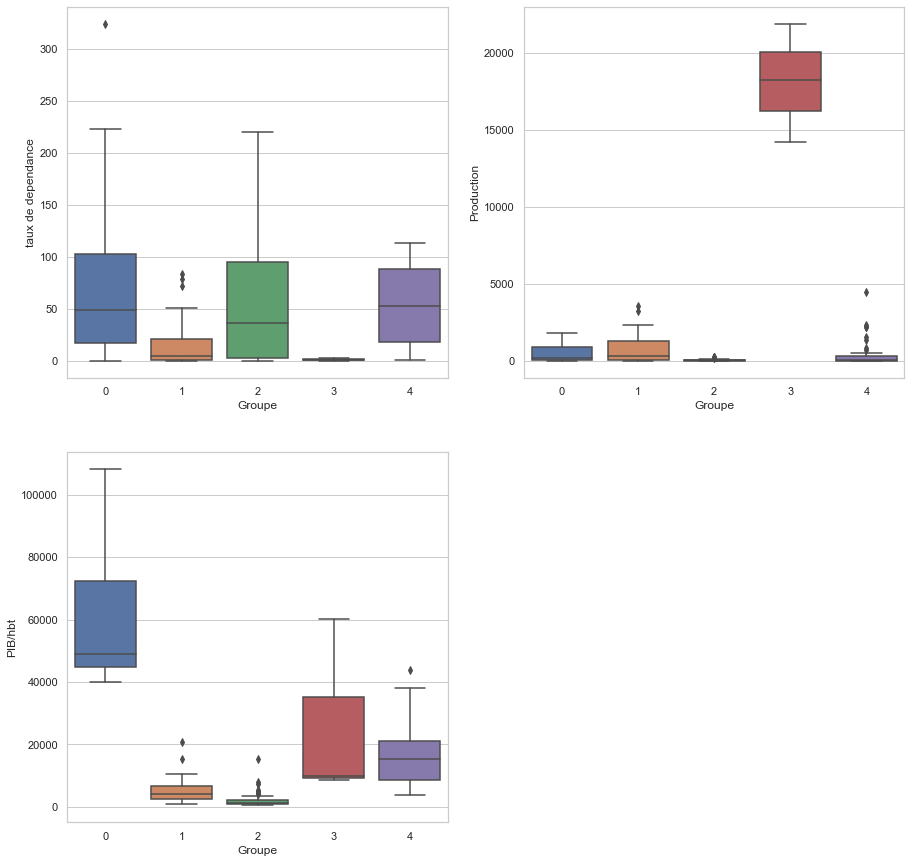

In [50]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(15, 15))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df_groupes_kmean5, x='Groupe', y='taux de dependance')

plt.subplot(222)
sns.boxplot(data=df_groupes_kmean5, x='Groupe', y='Production')
plt.subplot(223)
sns.boxplot(data=df_groupes_kmean5, x='Groupe', y='PIB/hbt')
plt.savefig("P9_picture/boxplot_k-means52.png")
plt.show

In [51]:
df_groupes_kmean5.groupby('Groupe').mean()

,Dispo_alimentaire (Kcal),Disponibilité intérieure,dispo proteine animale(g/pers/jour),part proteine animale,taux de dependance,Production,taux_crois_demo,PIB/hbt
Groupe,,,,,,,,
0,3444.736842,498.421053,68.778947,61.669474,77.550000,484.210526,0.929474,58393.708792
1,2857.222222,797.733333,29.526667,38.731556,14.872889,760.000000,1.145333,5370.038093
2,2412.294118,89.450980,15.639216,25.310588,54.430784,50.823529,2.482941,2069.597432
3,3425.666667,15469.666667,54.666667,53.370000,1.063333,18117.000000,0.656667,26235.037892
4,3089.500000,378.729167,51.450000,55.272083,54.418125,397.645833,0.282500,16686.951699


### Analyse des centroids et choix des pays  selon la méthode de K-means

**Le cluster 3** regroupe les pays avec de fortes disponibilités alimentaires, intérieures, en proteine et ayant un fort PIB/hbt. Mais ils produisent beaucoup de vollaille et en importent 1%: **Ils sont à exclure de notre selection**.

**Le cluster 1** regroupe les pays avec de disponibilités alimentaires, intérieures moyenne, ils ne consomment pas beaucoup de viande et les importations représentent 14% de leur disponibilité en vollaille, leur PIB/hbt n'est pas elévé: **Ils sont à exclure de notre selection**.

**Le cluster 2** regroupe les pays avec de faibles disponibilités alimentaires, intérieures, en proteine, il importent plus de 54% de leur vollaille, mais ne consomment pas beaucoup de viande et ont un PIB/hbt faible et une croissance démographique conséquente. Malgré cela **Ils sont à exclure de notre selection** car ils constituent pas un marché pertinent.

**Le cluster 4** regroupe les pays avec de moyennes disponibilités alimentaires, intérieures, en proteine et ayant un fort PIB/hbt. Mais ils importent beaucoup de vollaille 55%: **dans une certaine mesure, on peut les inclure dans notre selection**.

**Le cluster 0** regroupe les pays avec de fortes disponibilités alimentaires, une disponibilité intérieure moyenne, ils consomment beaucoup de viande et importent plus de 70% de leur disponibilté en volaille. par ailleurs ils ont un fort Pib/Hbt et un taux de croissance démographique supérieur à 1%: **ce sont les candidats par excellence, ils sont à inclure dans notre selection**



In [52]:
print(df_groupe0_Kmeans['Zone'].unique())

['Allemagne' 'Australie' 'Autriche' 'Belgique' 'Canada'
 'Chine - RAS de Hong-Kong' 'Chine - RAS de Macao' 'Danemark' 'Finlande'
 'Irlande' 'Islande' 'Israël' 'Luxembourg' 'Norvège' 'Pays-Bas'
 "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord" 'Suisse' 'Suède'
 'Émirats arabes unis']


#### Sous-ensemble des groupes validés via le K-mean5:
#### 'Allemagne' 'Australie' 'Autriche' 'Belgique' 'Canada' 'Chine - RAS de Hong-Kong' 'Chine - RAS de Macao'
#### 'Danemark' 'Finlande''Irlande' 'Islande' 'Israël' 'Koweït' 'Luxembourg' 'Norvège''Suisse' 'Suède'
####  'Nouvelle-Zélande' 'Pays-Bas' "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord"  'Émirats arabes unis'  

# Réalisation de l' ACP 

L'ACP (Analyse en Composante Principale) permettra une visualisation des clusters pays sur le premier plan factoriel (ou plus). Il deviendra alors facile de pouvoir appréhender le "comportement" des différents groupes.Elle permet de projeter sur un plan, dit factoriel, un nuage de points ayant plus de 3 dimensions. Ici, nos données ont 8 variables donc 8 dimensions.

# ACP

In [53]:
import sklearn
import numpy
import pandas
import matplotlib.pyplot as plt

In [54]:
#classe pour standardisation 
from sklearn.preprocessing import StandardScaler
#nombre d'observations
n = X_scaled.shape[0]
#nombre de variables
p = X_scaled.shape[1]
#classe pour l'ACP
from sklearn.decomposition import PCA
#instanciation(valeurs singulières)
pca = PCA(svd_solver='full')

In [55]:
Decomp= pca.fit(X_scaled)
#Pourcentage de variance expliquée par les composantes principales à l'aide de .explained_variance_ratio_
print(pca.explained_variance_ratio_.cumsum())

[0.46236167 0.71212367 0.83105331 0.91994906 0.96430545 0.99415841
 0.99852129 1.        ]


In [56]:
#variance expliquée
eigval = (n-1)/n*pca.explained_variance_
print(eigval)

[3.69889333 1.99809606 0.9514371  0.71116597 0.35485112 0.23882368
 0.03490308 0.01182965]


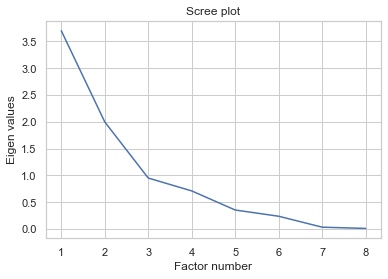

In [57]:
#cumul de variance expliquée
#nombre d'observations
n = X.shape[0]
#nombre de variables
p = X.shape[1]
plt.plot(numpy.arange(1,p+1),eigval)
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.show()


In [58]:
import pandas
import numpy
eig = pandas.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(p)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : numpy.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : numpy.round(numpy.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,3.721311,46.0,46.0
1,Dim2,2.010206,25.0,71.0
2,Dim3,0.957203,12.0,83.0
3,Dim4,0.715476,9.0,92.0
4,Dim5,0.357002,4.0,96.0
5,Dim6,0.240271,3.0,99.0
6,Dim7,0.035115,0.0,100.0
7,Dim8,0.011901,0.0,100.0


***Le premier plan factoriel explique 71% de notre modèle, on se limiter à K* = 2 composantes pour pouvoir représenter les individus et les variables***

#### Visualisation des variables sur le premier plan factoriel: cercle de correlation

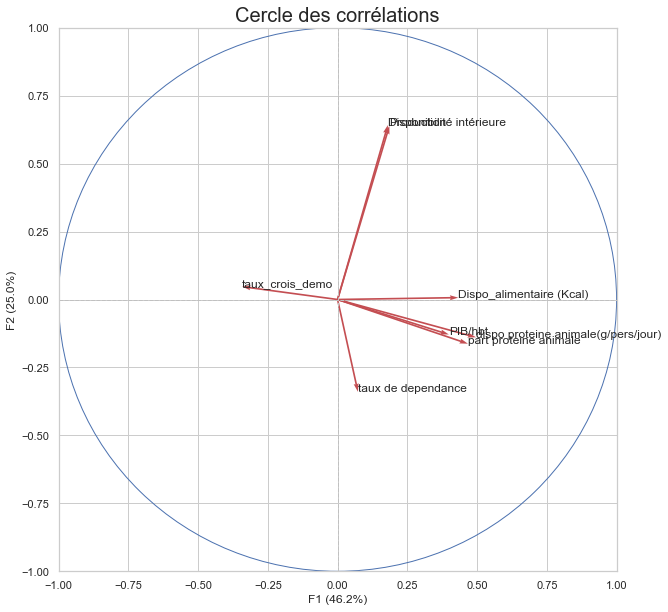

In [59]:
#Cercle des corrélations de nos variables
pcs = pca.components_

fig = plt.subplots(figsize=(10,10))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
           pcs[0,:], pcs[1,:], 
           angles='xy', scale_units='xy', scale=1, color='r', width= 0.003)

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.text(x, y, X.columns[i])
    
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

#Ajout des axes
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)

plt.title('Cercle des corrélations', fontsize=20)
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))

plt.savefig("p9_picture/cercle_correlation.png")
plt.show()

#### Tableau de la matrice de correlation entre les variables et le 1er plan factoriel

In [60]:
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
variable,,,,,,,,
Dispo_alimentaire (Kcal),0.432452,0.006885,-0.145390,0.242502,0.829014,0.060702,-0.204971,0.005535
Disponibilité intérieure,0.180294,0.641714,0.217689,-0.088859,-0.026251,-0.020207,0.011166,-0.706534
dispo proteine animale(g/pers/jour),0.496304,-0.139207,0.011150,0.041296,-0.095797,0.315862,0.789619,0.005458
part proteine animale,0.467194,-0.162697,0.011129,-0.135276,-0.379337,0.518725,-0.568811,-0.017840
taux de dependance,0.072914,-0.339558,0.798109,-0.410998,0.232284,-0.139238,-0.011609,0.002963
Production,0.185795,0.638905,0.215008,-0.092566,-0.043253,-0.011594,-0.007836,0.707402
taux_crois_demo,-0.342112,0.047336,0.463000,0.649764,0.030444,0.493067,-0.010695,0.001225
PIB/hbt,0.398766,-0.128715,0.183442,0.560010,-0.319719,-0.603677,-0.102504,-0.001536


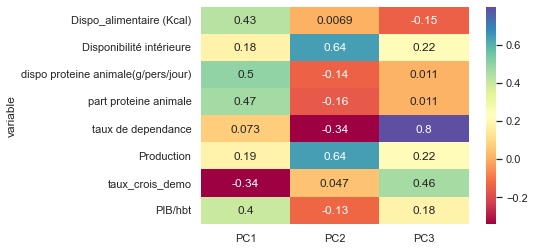

In [61]:
# get correlation matrix plot for loadings
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(loadings_df.loc[:,['PC1','PC2', 'PC3']], annot=True, cmap='Spectral')
plt.show()

#### Contribution des variables au plan factoriel

In [62]:
n = X.shape[0] # nb individus
p = X.shape[1] # nb variables
eigval = (n-1) / n * pca.explained_variance_ # valeurs propres
sqrt_eigval = numpy.sqrt(eigval) # racine carrée des valeurs propres
corvar = numpy.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pandas.DataFrame({'id':X.columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1],'COR_3': corvar[:,2]})
coordvar

,id,COR_1,COR_2,COR_3
0,Dispo_alimentaire (Kcal),0.831715,0.009732,-0.141815
1,Disponibilité intérieure,0.346751,0.907088,0.212338
2,dispo proteine animale(g/pers/jour),0.954517,-0.196775,0.010875
3,part proteine animale,0.898531,-0.229978,0.010855
4,taux de dependance,0.140232,-0.479979,0.778488
5,Production,0.357330,0.903117,0.209722
6,taux_crois_demo,-0.657968,0.066911,0.451617
7,PIB/hbt,0.766927,-0.181944,0.178932


In [63]:
# contribution des variables#cosinus carré des variables
cos2var = corvar**2
#contributions
ctrvar = cos2var
for k in range(p):
 ctrvar[:,k] = ctrvar[:,k]/eigval[k]
#on n'affiche que pour les deux premiers axes
print(pandas.DataFrame({'id':X.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1],'CTR_3':ctrvar[:,2]}))

                                    id     CTR_1     CTR_2     CTR_3
0             Dispo_alimentaire (Kcal)  0.187015  0.000047  0.021138
1             Disponibilité intérieure  0.032506  0.411797  0.047389
2  dispo proteine animale(g/pers/jour)  0.246318  0.019379  0.000124
3                part proteine animale  0.218270  0.026470  0.000124
4                   taux de dependance  0.005316  0.115300  0.636977
5                           Production  0.034520  0.408199  0.046228
6                      taux_crois_demo  0.117041  0.002241  0.214369
7                              PIB/hbt  0.159014  0.016568  0.033651


### Caractérisation des axes

Le premier axe est constitué de pays ayant une forte disponibilité alimentaire et en proteine animale, ils consomment beaucoup de viande et ont un PIB/hbt elévé, ils s'opposent à ceux qui ont un taux de croissance démographique élévé. Plus la valeur de l’axe PC1 sera positive et plus le pays aura un PIB élevé, une forte consommation en protéines animales et une forte disponibilité alimentaire en protéines et en kilocalories.c'est l'axe de regime alimentaire

Le second se caracterise par une disponibilité intérieure et une production élevée de volaille, il s'oppose aux pays ayant une forte dépendance aux importations de vollaille, ayant une faible dispo en proteine animale.

Il existe une certaines relation entre les variables de PIB, de ratio de protéines animales et de disponibilité en protéines totales et en kilocalories. 

### Projection des pays sur le 1er plan factoriel

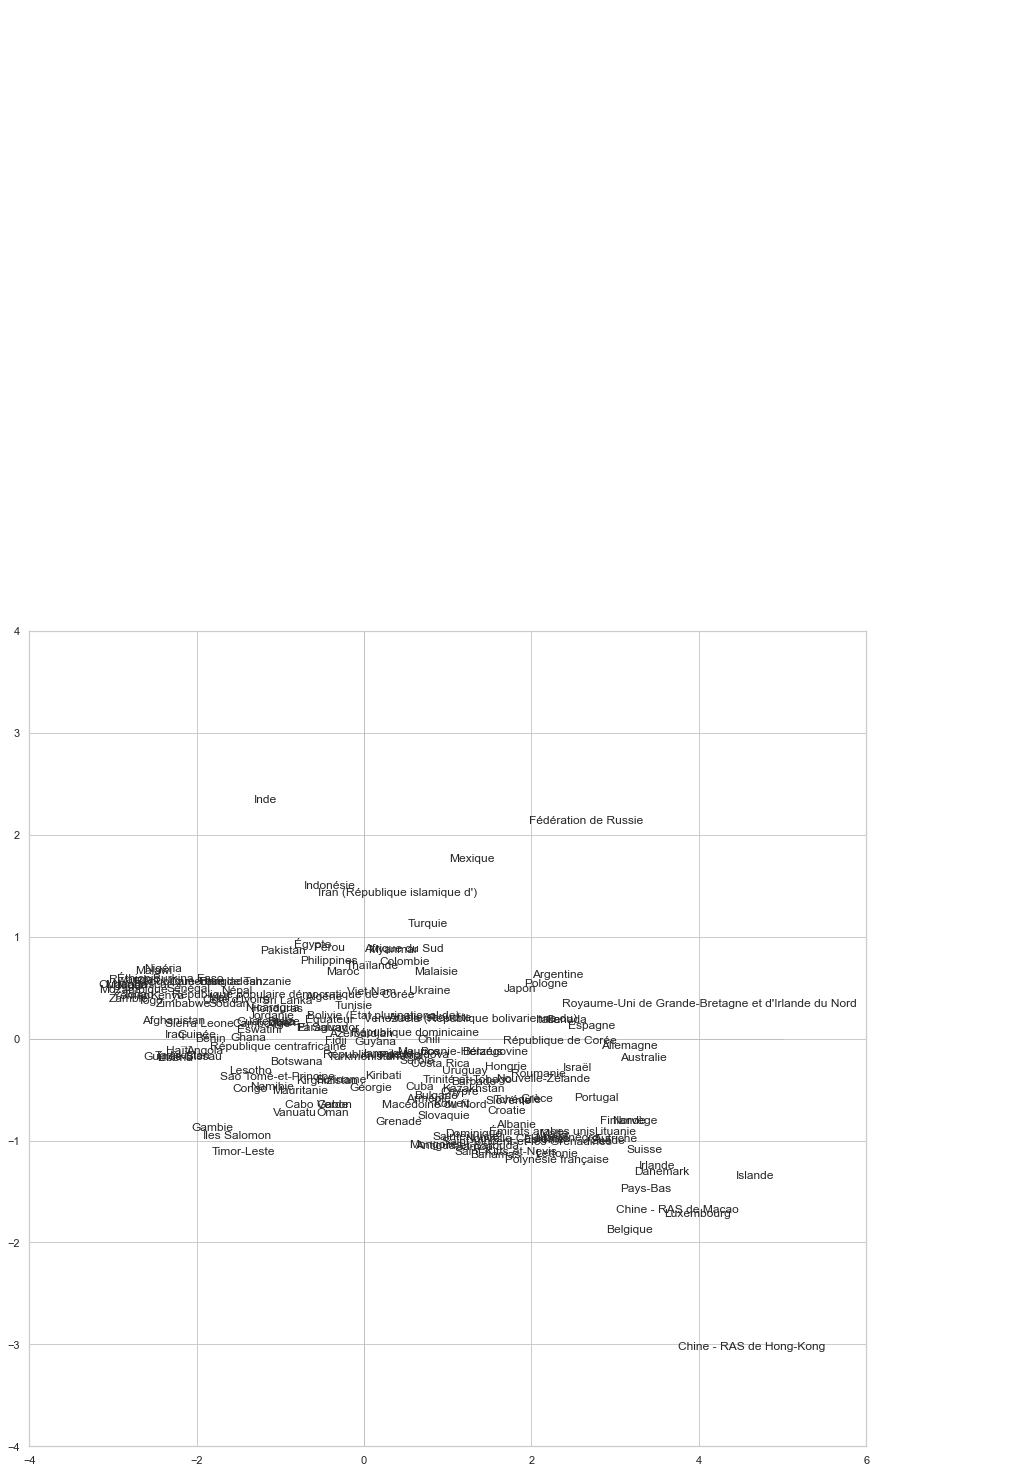

In [64]:
coord = pca.fit_transform(X_scaled)
#positionnement des individus dans le premier plan
fig, axes = plt.subplots(figsize=(15,15))
axes.set_xlim(-4,6) #même limites en abscisse
axes.set_ylim(-4,4) #et en ordonnée
#placement des étiquettes des observations
for i in range(n):
    plt.annotate(X.index[i],(coord[i,0],coord[i,1]))
#ajouter les axes
plt.plot([-5,5],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-5,5],color='silver',linestyle='-',linewidth=1)
#affichage
plt.show()

Cette projection est très intéressante car elle nous apporte une vision du potentiel des pays. Par exemple, les pays plus à droite présentent un meilleur PIB/habitant avec un potientiel en disponibilité protéines et caloriques élevées , ceux qui sont plus bas à droite ont de forts taux de dépendance. 

### Contribution des pays dans l'inertie totale

In [65]:
pandas.set_option('display.max_rows', None)
#contribution des individus dans l'inertie totale
di = numpy.sum(X_scaled**2,axis=1)
print(pandas.DataFrame({'ID':X.index,'d_i':di,}).sort_values(by = 'd_i', ascending = False))

                                                    ID         d_i
163                              États-Unis d'Amérique  150.622025
33                                 Chine, continentale  113.728420
21                                              Brésil   49.725384
31                            Chine - RAS de Hong-Kong   44.027392
84                                          Luxembourg   31.538957
68                                             Islande   26.521763
16                                            Belgique   20.821809
32                                Chine - RAS de Macao   19.273360
138                                             Suisse   17.490093
67                                             Irlande   16.617591
146                                        Timor-Leste   15.840457
103                                            Norvège   15.647356
51                                              Gambie   14.861059
112                                           Pays-Bas   14.78

In [66]:
#qualité de représentation des individus - COS2
cos2 = coord**2
for j in range(p):
    cos2[:,j] = cos2[:,j]/di
print(pandas.DataFrame({'id':X.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}))

                                                    id        COS2_1    COS2_2
0                                          Afghanistan  9.336458e-01  0.002665
1                                       Afrique du Sud  1.795261e-05  0.775746
2                                              Albanie  4.474034e-01  0.136481
3                                              Algérie  1.204604e-01  0.035105
4                                            Allemagne  9.389448e-01  0.001063
5                                               Angola  6.421731e-01  0.003053
6                                   Antigua-et-Barbuda  7.920943e-02  0.251418
7                                      Arabie saoudite  4.566971e-02  0.017542
8                                            Argentine  6.348716e-01  0.055642
9                                              Arménie  1.348395e-01  0.203855
10                                           Australie  7.114358e-01  0.003728
11                                            Autric

# Analyse des groupes obtenus des méthodes de clustering sur notre plan factoriel

### Projection des groupes issus du k-means dans le premier plan factoriel

C:\Users\carol\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\carol\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


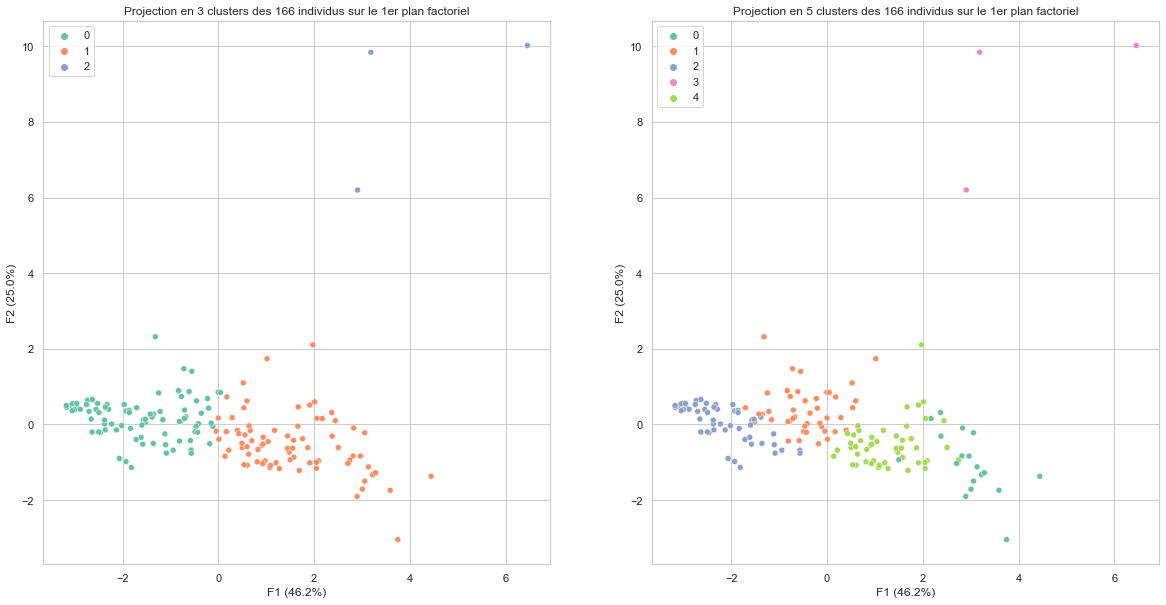

In [67]:
plt.figure(figsize=(20, 10))
X_projected = pca.transform(X_scaled)

plt.subplot(121)
sns.scatterplot(X_projected[:, 0], X_projected[:, 1], hue=cls3.labels_,palette="Set2")
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 3 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))


plt.subplot(122)
sns.scatterplot( X_projected[:, 0], X_projected[:, 1], hue=cls5.labels_, palette="Set2")
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 5 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

plt.savefig("p9_picture/projection k-mean.png")

### Projection des groupes issus de k-means et leurs centroids sur le premier plan factoriel

C:\Users\carol\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


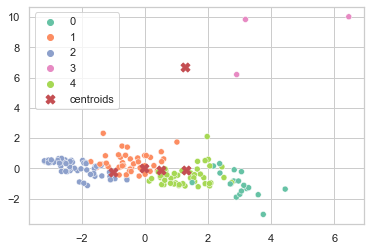

C:\Users\carol\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Projection en 5 clusters des 166 individus sur le 1er plan factoriel')

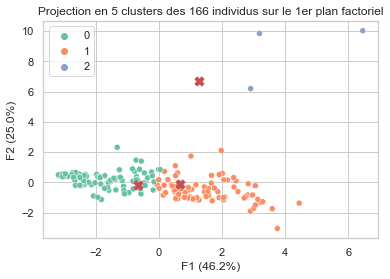

In [68]:

sns.scatterplot( X_projected[:, 0], X_projected[:, 1], hue=cls5.labels_, palette="Set2")
#sns.scatterplot(data=df, x="var1", y="var2", hue=kmeans.labels_)
plt.scatter(cls5.cluster_centers_[:,0], cls5.cluster_centers_[:,1], 
            marker="X", c="r", s=80, label="centroids")
plt.legend()
plt.show()
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 5 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

sns.scatterplot( X_projected[:, 0], X_projected[:, 1], hue=cls3.labels_, palette="Set2")
#sns.scatterplot(data=df, x="var1", y="var2", hue=kmeans.labels_)
plt.scatter(cls3.cluster_centers_[:,0], cls3.cluster_centers_[:,1], 
            marker="X", c="r", s=80, label="centroids")

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 5 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

On exclut le partitionnement en 03 clusters pour K-means

### Projection des clusters obtenus de k-means(k=5) et de la CAH sur le premier plan factoriel issu de l'ACP

C:\Users\carol\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\carol\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


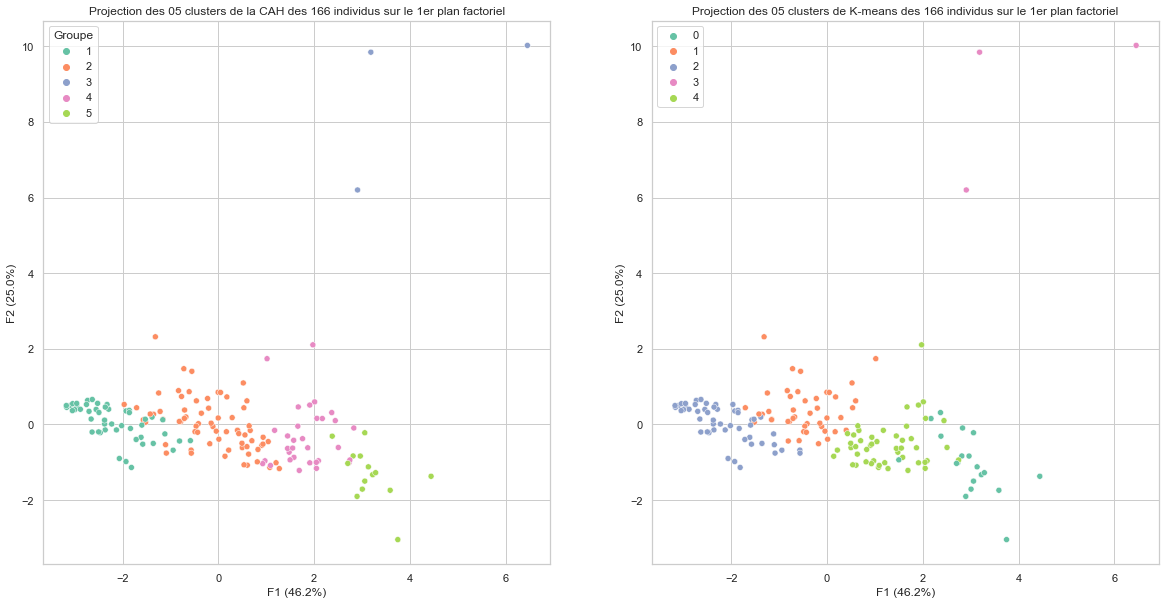

In [69]:
#Coordonnées factorielles 
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(20, 10))

plt.subplot(121)
sns.scatterplot(X_projected[:, 0], X_projected[:, 1], hue=df_groupes_cah['Groupe'], palette="Set2")
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection des 05 clusters de la CAH des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

plt.subplot(122)
sns.scatterplot(X_projected[:, 0], X_projected[:, 1], hue=cls5.labels_, palette="Set2")
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection des 05 clusters de K-means des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

plt.savefig("p9_picture/projection k-mean_CAH.png")
plt.show()


## Selection des pays

Sous-ensemble des groupes validés via la classification hiérarchique:
'Australie', 'Belgique', 'Chine - RAS de Hong-Kong','Chine - RAS de Macao', 'Danemark', 'Finlande', 'Irlande',¶
'Islande', 'Israël', 'Luxembourg', 'Norvège', 'Pays-Bas', 'Suisse', 'Suède'
Pays validés par la méthode de k-means:
**'Allemagne' 'Australie' 'Autriche' 'Belgique' 'Canada' 'Chine - RAS de Hong-Kong' 'Chine - RAS de Macao'
'Danemark' 'Finlande''Irlande' 'Islande' 'Israël' 'Koweït' 'Luxembourg' 'Norvège''Suisse' 'Suède'
'Nouvelle-Zélande' 'Pays-Bas' "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord"  'Émirats arabes unis'


Nous avons des pays qui reviennent dans les deux resultats: nous allons les priviligier: 
'Australie', 'Belgique', 'Chine - RAS de Hong-Kong','Chine - RAS de Macao', 'Danemark', 'Finlande', 'Irlande',¶
'Islande', 'Israël', 'Luxembourg', 'Norvège', 'Pays-Bas', 'Suisse', 'Suède'
        

***La contribution  des pays dans l'inertie totale de l'ACP est un excellent moyen de discrimination, elle nous permet d'affiner notre selection***

On va choisir les 10 pays qui contribuent le plus à l'inertie de notre ACP, et faire un croisement

In [70]:
PAYS_inertie= pandas.DataFrame({'ID':X.index,'d_i':di,})
PAYS_inertie

,ID,d_i
0,Afghanistan,7.555324
1,Afrique du Sud,0.930703
2,Albanie,5.575931
3,Algérie,4.120779
4,Allemagne,8.526923
5,Angola,7.047155
6,Antigua-et-Barbuda,4.628186
7,Arabie saoudite,1.830375
8,Argentine,6.369323
9,Arménie,1.851119


In [71]:
top_10= PAYS_inertie.sort_values(by = 'd_i', ascending = False).head(10)

In [72]:
top_10

,ID,d_i
163,États-Unis d'Amérique,150.622025
33,"Chine, continentale",113.728420
21,Brésil,49.725384
31,Chine - RAS de Hong-Kong,44.027392
84,Luxembourg,31.538957
68,Islande,26.521763
16,Belgique,20.821809
32,Chine - RAS de Macao,19.273360
138,Suisse,17.490093
67,Irlande,16.617591


les 03 pays qui contribuent le plus au modèle sont ceux du groupe et ont été exclus de notre liste.
Il reste 03 pays par ordre qui sont:
***Chine - RAS de Hong-Kong
Luxembourg
Islande
Belgique
Chine - RAS de Macao
Suisse
Irlande***

In [73]:
etats_select=['Chine - RAS de Hong-Kong', 'Luxembourg', 'Islande', 'Belgique', 'Chine - RAS de Macao', 'Suisse', 'Irlande']
data_selection=X[X.index.isin(etats_select)]
data_selection

,Dispo_alimentaire (Kcal),Disponibilité intérieure,dispo proteine animale(g/pers/jour),part proteine animale,taux de dependance,Production,taux_crois_demo,PIB/hbt
Zone,,,,,,,,
Belgique,3782.0,152.0,57.7,58.70,222.37,463.0,0.58,44020.066762
Chine - RAS de Hong-Kong,3233.0,280.0,93.7,72.64,323.93,24.0,0.83,46705.027813
Chine - RAS de Macao,3288.0,19.0,66.7,62.92,121.05,3.0,1.69,81516.664768
Irlande,3766.0,128.0,66.7,58.87,77.34,110.0,1.08,71391.006104
Islande,3593.0,10.0,102.0,72.19,20.00,10.0,0.63,73231.725965
Luxembourg,3466.0,11.0,69.0,62.39,100.00,0.0,2.20,108431.931751
Suisse,3383.0,133.0,61.0,63.34,38.35,91.0,0.95,83313.013992


# HEATMAP

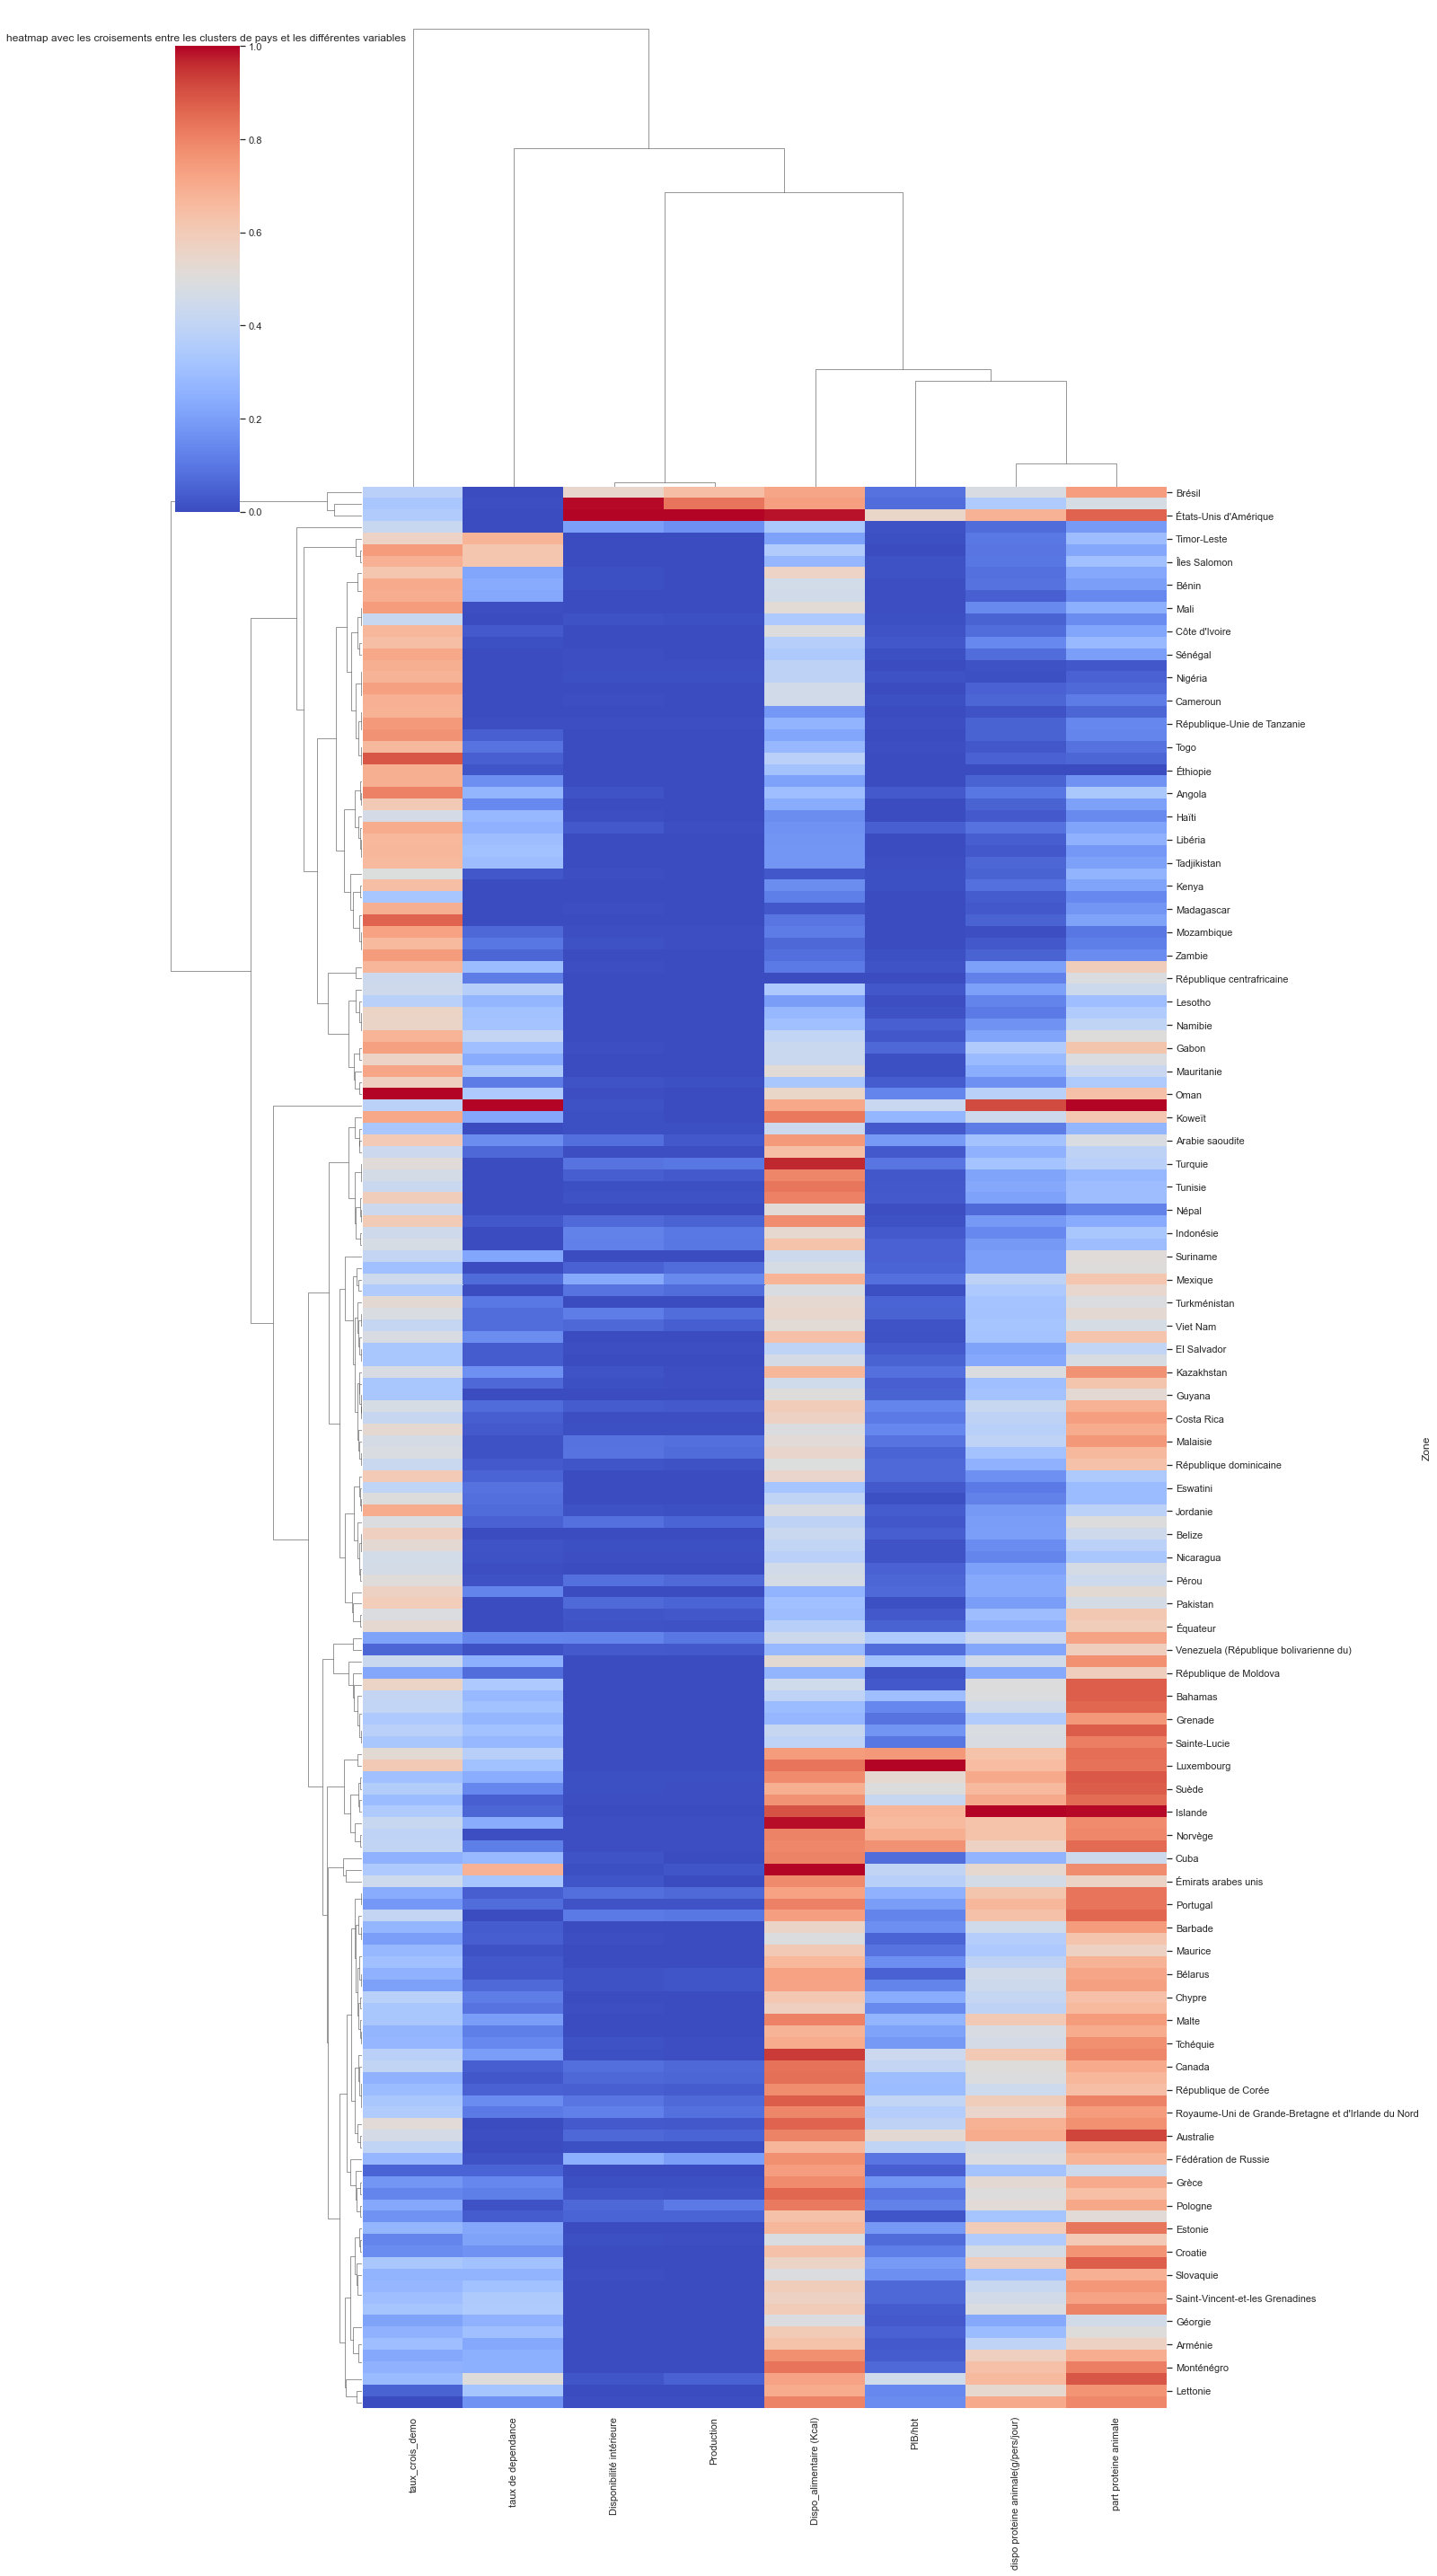

In [74]:
#role = pd.DataFrame(X_scaled, columns=X.columns)
import seaborn as sns; sns.set_theme(color_codes=True)
dat = X
pays=X.index
g = sns.clustermap(dat, metric="correlation" , standard_scale=1, cmap='coolwarm', figsize=(20,40))
plt.title("heatmap avec les croisements entre les clusters de pays et les différentes variables ")
plt.savefig("p9_picture/Heatmap1.png")

# Conclusion

Le clustering nous a permis d'identifier un certain nombre de pays, mais qui différaient selon la méthode utilisée, K-means ou CAH.  en faisant une intersection entre les deux, nous avons pu avoir une short-list de 07 pays. Grâce à l'ACP qui a bien  discriminé les différents groupes, nous avons ces 07 pays qui ont les plus grandes inerties en ACP. les 03 premiers important très peu de volaille

Recommandations de pays à clibler :
Si nous voulons un développement "plus rapide" tourné vers l'UE avec des pays à fort potientiel: 

***le Luxembourg ***

***l'Islande*** 

***la Belgique*** 

***La Suisse***

***L'Irlande***

Ces pays sont non seulement dans l'Union Européenne (facilité monétaire, logistique, etc…), et répondent à une position dominante en termes de disponibilité alimentaire, en protéines animales, PIB/habitant, mais sont assez ouverts à l'importation.

pour un développement tourné vers des pays hors UE, et toujours sur la même logique:

***Hong-Kong***

***Macao***

On aurait aussi pu utiliser L'algorithme DBSCAN (Density-Based Spatial Clustering of Applications with Noise) pour partitionner nos données. il permet de trouver des clusters de forme arbitraire.



### Je vous remercie###